--- INFO O STRUKTURZE ---
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16674 entries, 0 to 16673
Data columns (total 4 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   Nazwa               16674 non-null  object
 1   Transakcje rynkowe  16674 non-null  object
 2   Rok                 16674 non-null  int64 
 3   Wartosc             16674 non-null  object
dtypes: int64(1), object(3)
memory usage: 521.2+ KB
None

Liczba wartości z '-' w kolumnie 'Wartosc': 9

--- BRAKI W DANYCH ---
Nazwa                 0
Transakcje rynkowe    0
Rok                   0
Wartosc               0
cena_numeric          0
dtype: int64
Liczba zerowych cen w podziale na typ transakcji rynkowej:


,Transakcje rynkowe,Liczba_zerowych_cen
0,ogółem,109
1,rynek pierwotny,1457
2,rynek wtórny,112


------------------------------------------------------------
Liczba wierszy w df_clean przed usunięciem zer: 16674
Liczba wierszy w df_clean po usunięciu zer: 14996
------------------------------------------------------------

--- WARTOŚCI W KOLUMNIE GRUPUJĄCEJ ---
['ogółem' 'rynek pierwotny' 'rynek wtórny']
------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
Transakcje rynkowe,,,,,,,,
ogółem,5449.0,3451.77,1464.32,957.0,2483.00,3067.0,4088.00,16144.0
rynek pierwotny,4101.0,4419.51,1579.29,2018.0,3423.00,4067.0,5001.00,27720.0
rynek wtórny,5446.0,3261.27,1422.31,957.0,2335.25,2855.0,3829.75,15462.0


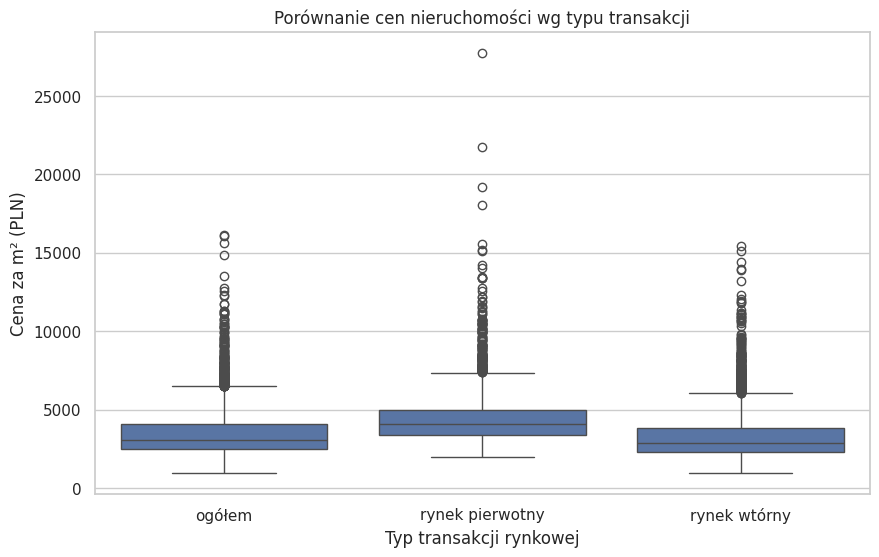

WNIOSKI: Można zauważyć znaczną liczbę outlierów, szczególnie w rynku ogółem i rynku wtórnym,
co sugeruje potrzebę dalszego czyszczenia danych w celu dokładniejszej analizy.
------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
Transakcje rynkowe,,,,,,,,
ogółem,5400.0,3384.84,1279.03,957.0,2477.0,3054.0,4061.75,9026.0
rynek pierwotny,4029.0,4293.84,1213.25,2018.0,3417.0,4044.0,4939.00,9023.0
rynek wtórny,5407.0,3205.13,1255.74,957.0,2332.0,2849.0,3807.00,9021.0


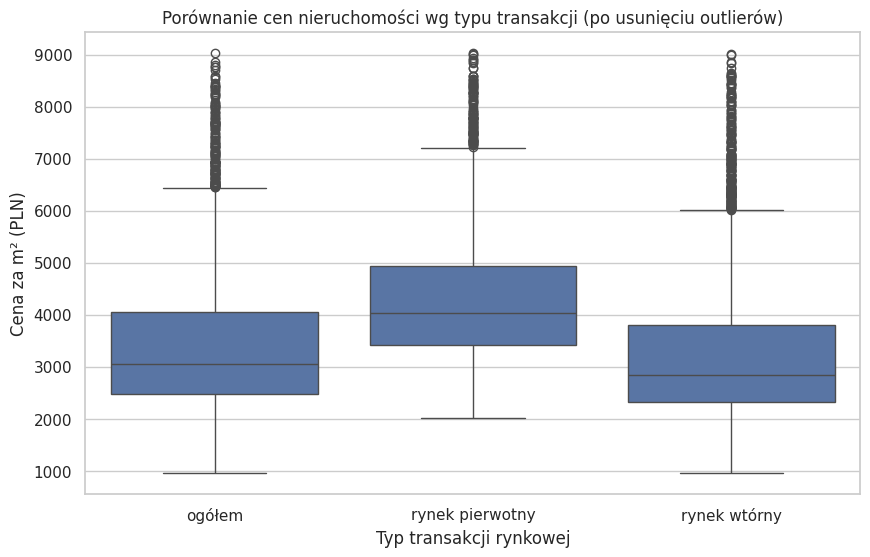

WNIOSKI: Po usunięciu outlierów rozkład cen stał się bardziej jednorodny, a mediany cen dla różnych typów transakcji są wyraźniej widoczne,
Rynek pierwotny wykazuje zazwyczaj wyższe ceny niż rynek wtórny, z rynkiem ogółem plasującym się gdzieś pomiędzy.
------------------------------------------------------------


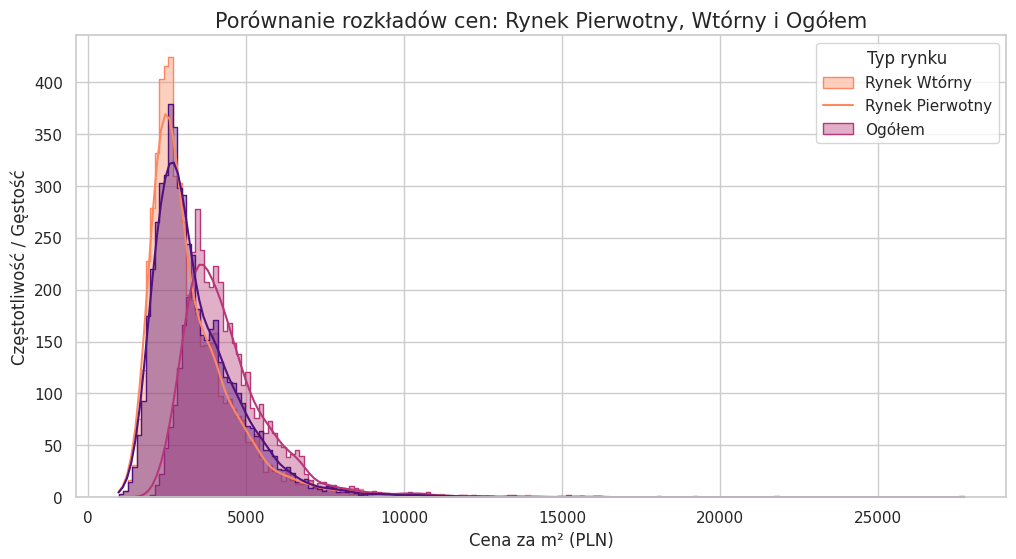

WNIOSKI: Rozkłady cen na poszczególnych rynkach są zróżnicowane. Rynek pierwotny ma tendencję do wyższych cen i bardziej rozproszonego rozkładu niż rynek wtórny.
Rozkład ogólny jest wypadkową tych dwóch, ale nadal charakteryzuje się asymetrią prawostronną, co wskazuje na dominację niższych cen z dłuższym ogonem w stronę wyższych wartości.
------------------------------------------------------------


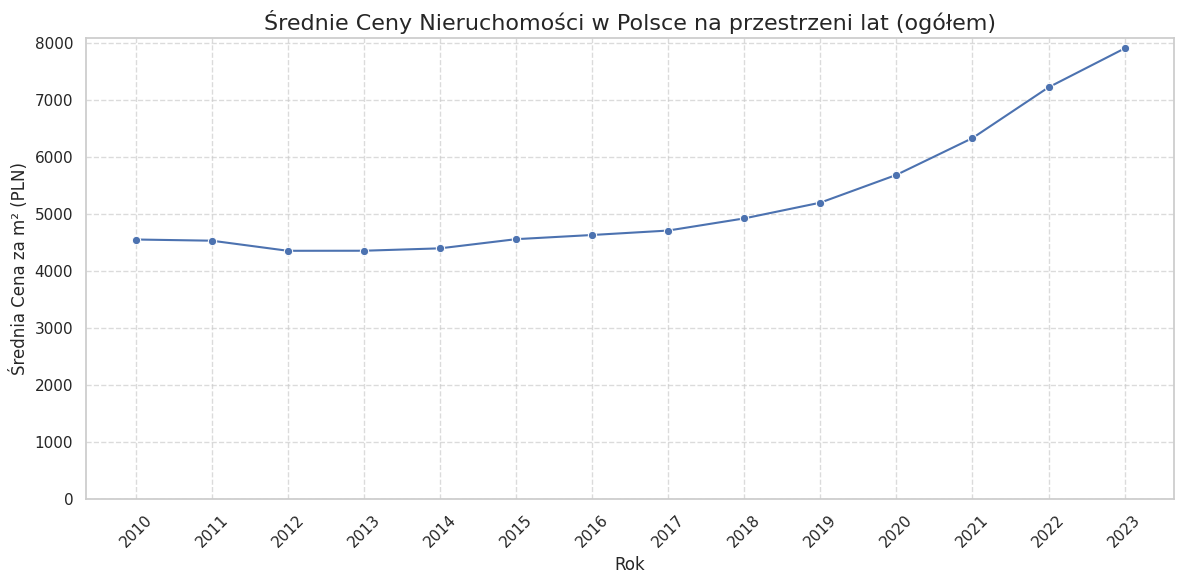

WNIOSKI: Wykres pokazuje wyraźny trend wzrostowy średnich cen nieruchomości w Polsce w badanym okresie,
co sugeruje rosnącą wartość nieruchomości w kraju. Szczególnie silny wzrost jest widoczny w ostatnich latach.
------------------------------------------------------------
------------------------------------------------------------


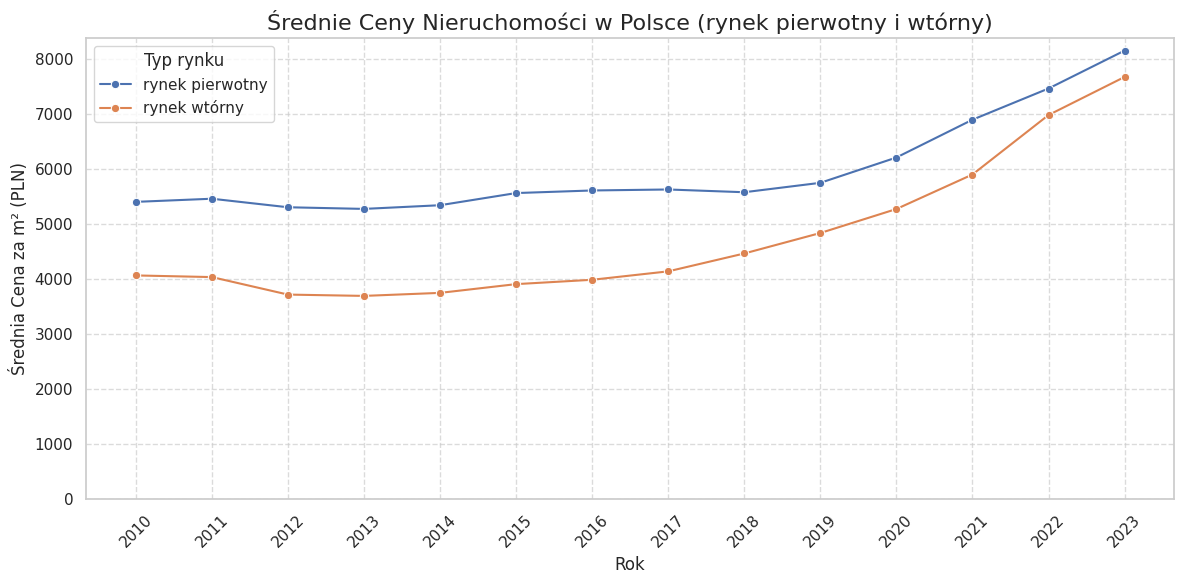

WNIOSKI: Ceny na rynku pierwotnym są konsekwentnie wyższe niż na rynku wtórnym przez cały analizowany okres.
Obie linie pokazują trend wzrostowy, ale rynek pierwotny wykazuje szybszy wzrost w ostatnich latach, co może świadczyć o większym zapotrzebowaniu na nowe mieszkania lub wyższych kosztach budowy.
------------------------------------------------------------


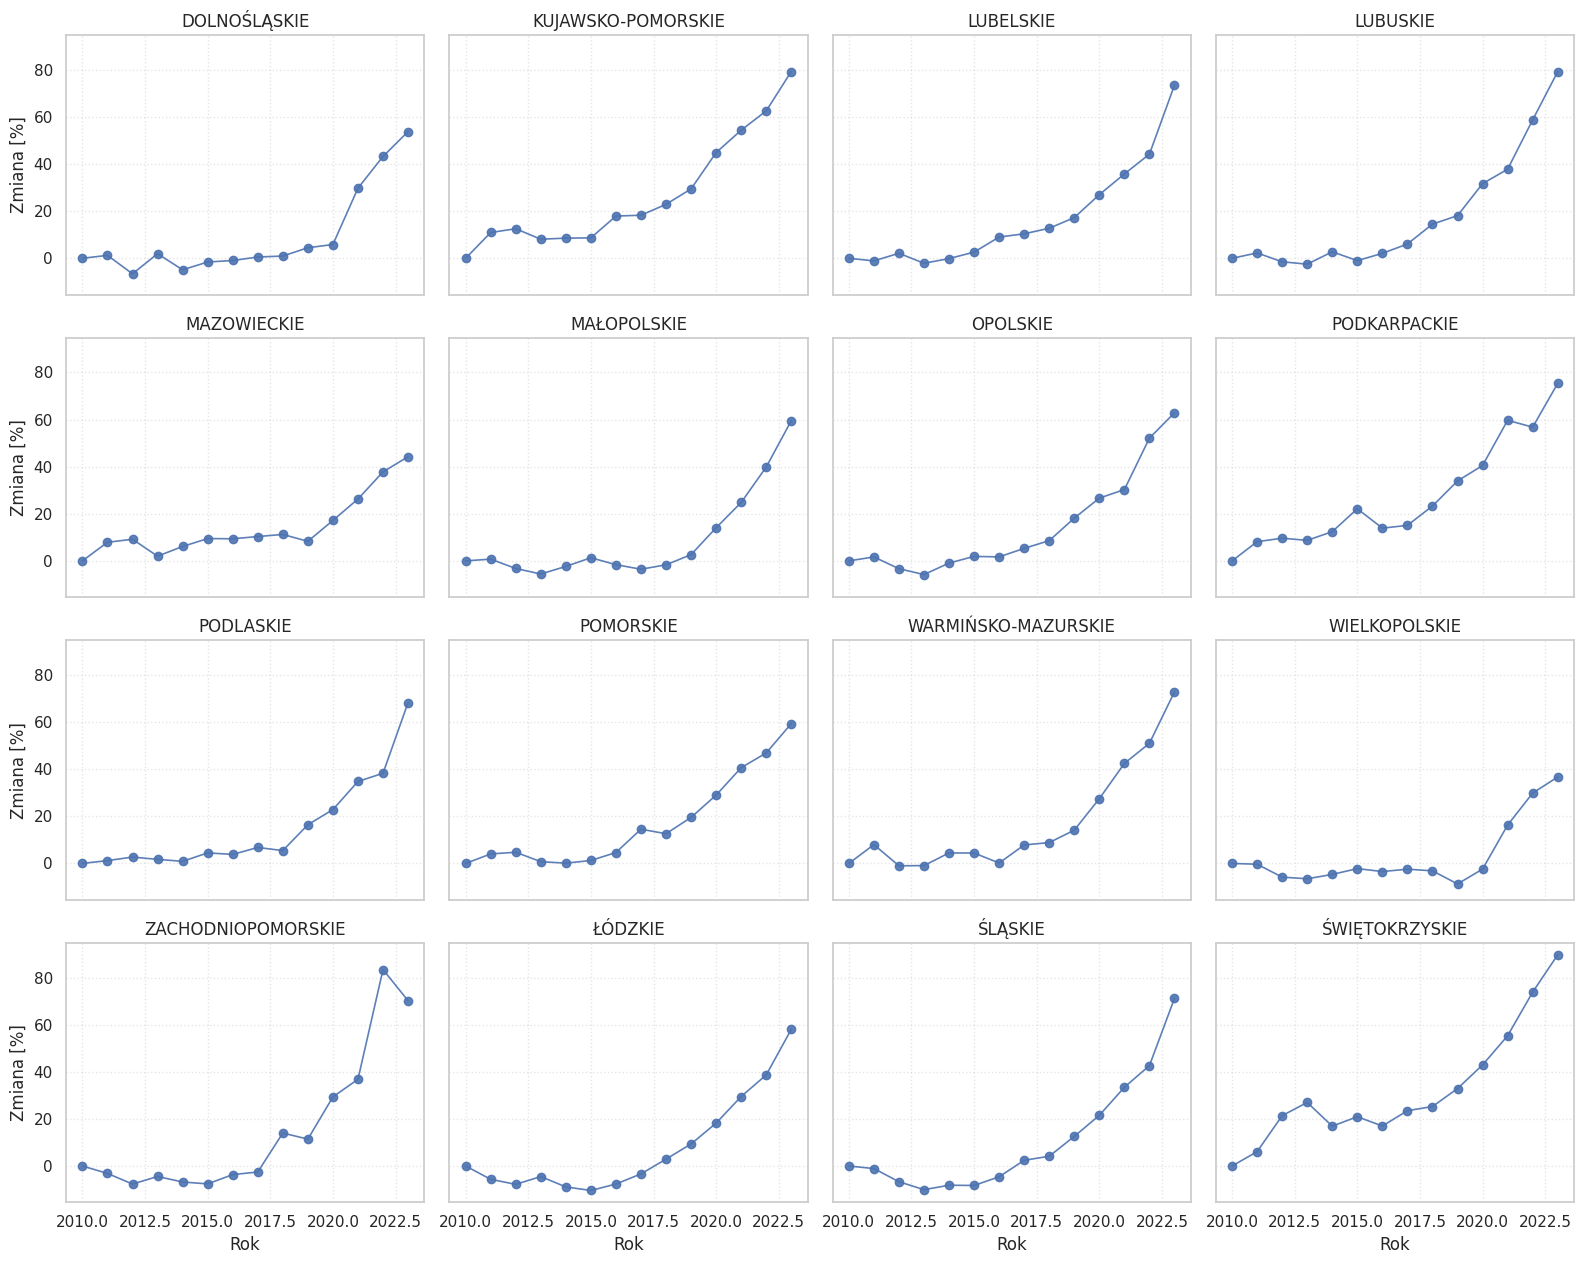

WNIOSKI: Wykresy te pozwalają na porównanie dynamiki zmian cen w różnych województwach. Można zauważyć, że niektóre regiony doświadczyły znacznie większych wzrostów cen niż inne,
co może być związane z lokalnymi czynnikami ekonomicznymi i demograficznymi. Niektóre województwa wykazują stabilniejszy wzrost, podczas gdy inne miały bardziej zmienny rozwój.
------------------------------------------------------------
Średnie ceny nieruchomości dla województw


,Nazwa,cena_numeric
0,DOLNOŚLĄSKIE,5004.785714
1,KUJAWSKO-POMORSKIE,4130.357143
2,LUBELSKIE,4766.428571
3,LUBUSKIE,3400.809524
4,MAZOWIECKIE,7395.571429
5,MAŁOPOLSKIE,6670.428571
6,OPOLSKIE,3641.047619
7,PODKARPACKIE,4146.452381
8,PODLASKIE,4582.452381
9,POMORSKIE,5909.500000


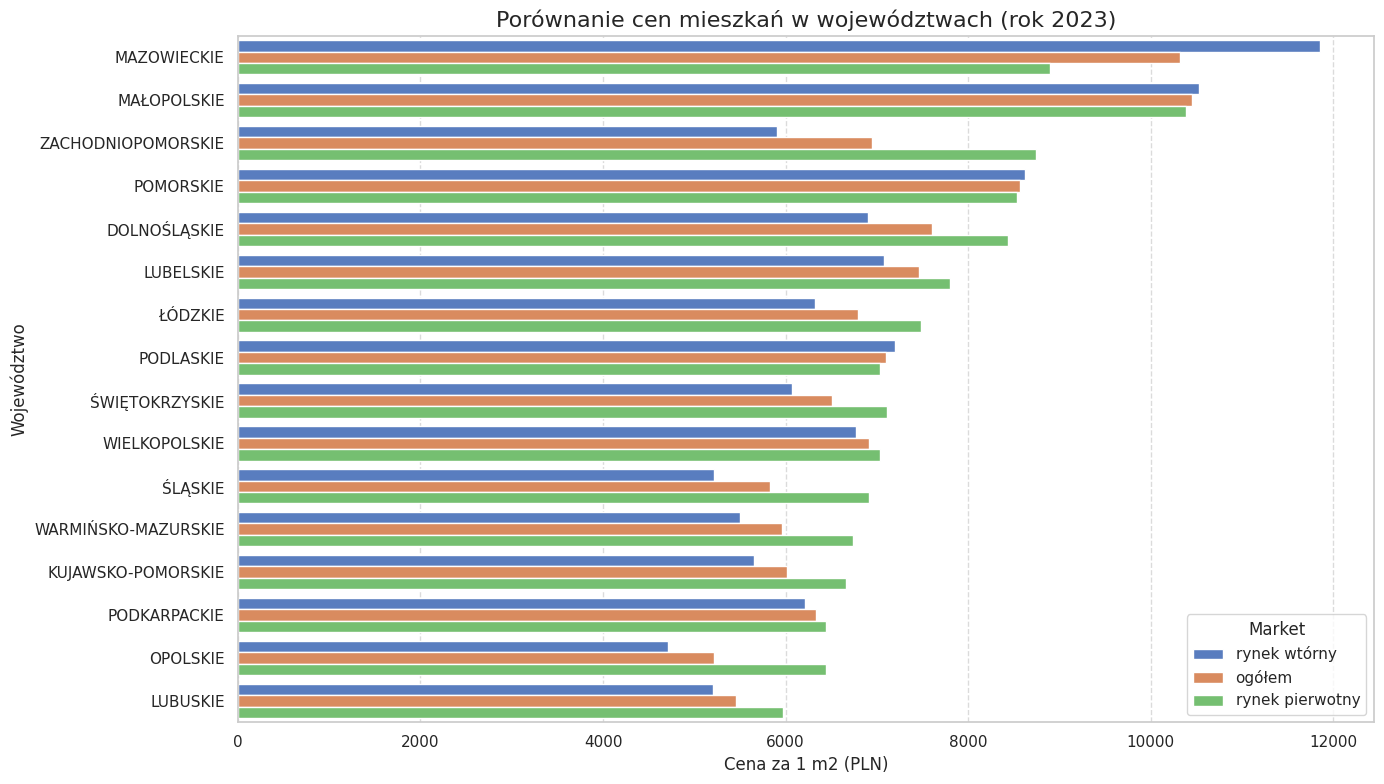

WNIOSKI: Wykres jasno pokazuje różnice w cenach mieszkań między rynkiem pierwotnym a wtórnym w poszczególnych województwach.
Widać, że niektóre województwa, takie jak Mazowieckie i Małopolskie, mają znacznie wyższe ceny ogółem, co jest zgodne z ich statusem gospodarczym i demograficznym.
Różnica między rynkiem pierwotnym a wtórnym jest różna w zależności od regionu, co może wskazywać na lokalne dynamiki podaży i popytu.
Summary Table:
Market               ogółem  rynek pierwotny  rynek wtórny  Różnica (P-W)
Region                                                                   
MAŁOPOLSKIE           10446            10383         10528           -145
MAZOWIECKIE           10317             8898         11852          -2954
ZACHODNIOPOMORSKIE     6945             8743          5900           2843
POMORSKIE              8571             8532          8623            -91
DOLNOŚLĄSKIE           7607             8435          6903           1532
LUBELSKIE              7460             780

,Województwo,Najdroższy Powiat,Cena Max [zł/m2],Najtańszy Powiat,Cena Min [zł/m2]
0,DOLNOŚLĄSKIE,Powiat m. Wrocław,10151,Powiat górowski,2591
1,KUJAWSKO-POMORSKIE,Powiat m. Toruń,7545,Powiat grudziądzki,3031
2,LUBELSKIE,Powiat m. Lublin,8593,Powiat zamojski,2892
3,LUBUSKIE,Powiat m. Zielona Góra,6708,Powiat żagański,3440
4,ŁÓDZKIE,Powiat m. Łódź,7365,Powiat skierniewicki,2927
5,MAŁOPOLSKIE,Powiat tatrzański,16104,Powiat suski,4466
6,MAZOWIECKIE,Powiat m. st. Warszawa,13498,Powiat przysuski,3800
7,OPOLSKIE,Powiat m. Opole,7140,Powiat głubczycki,2919
8,PODKARPACKIE,Powiat m. Rzeszów,7612,Powiat lubaczowski,2874
9,PODLASKIE,Powiat m. Białystok,7899,Powiat suwalski,3110


------------------------------------------------------------


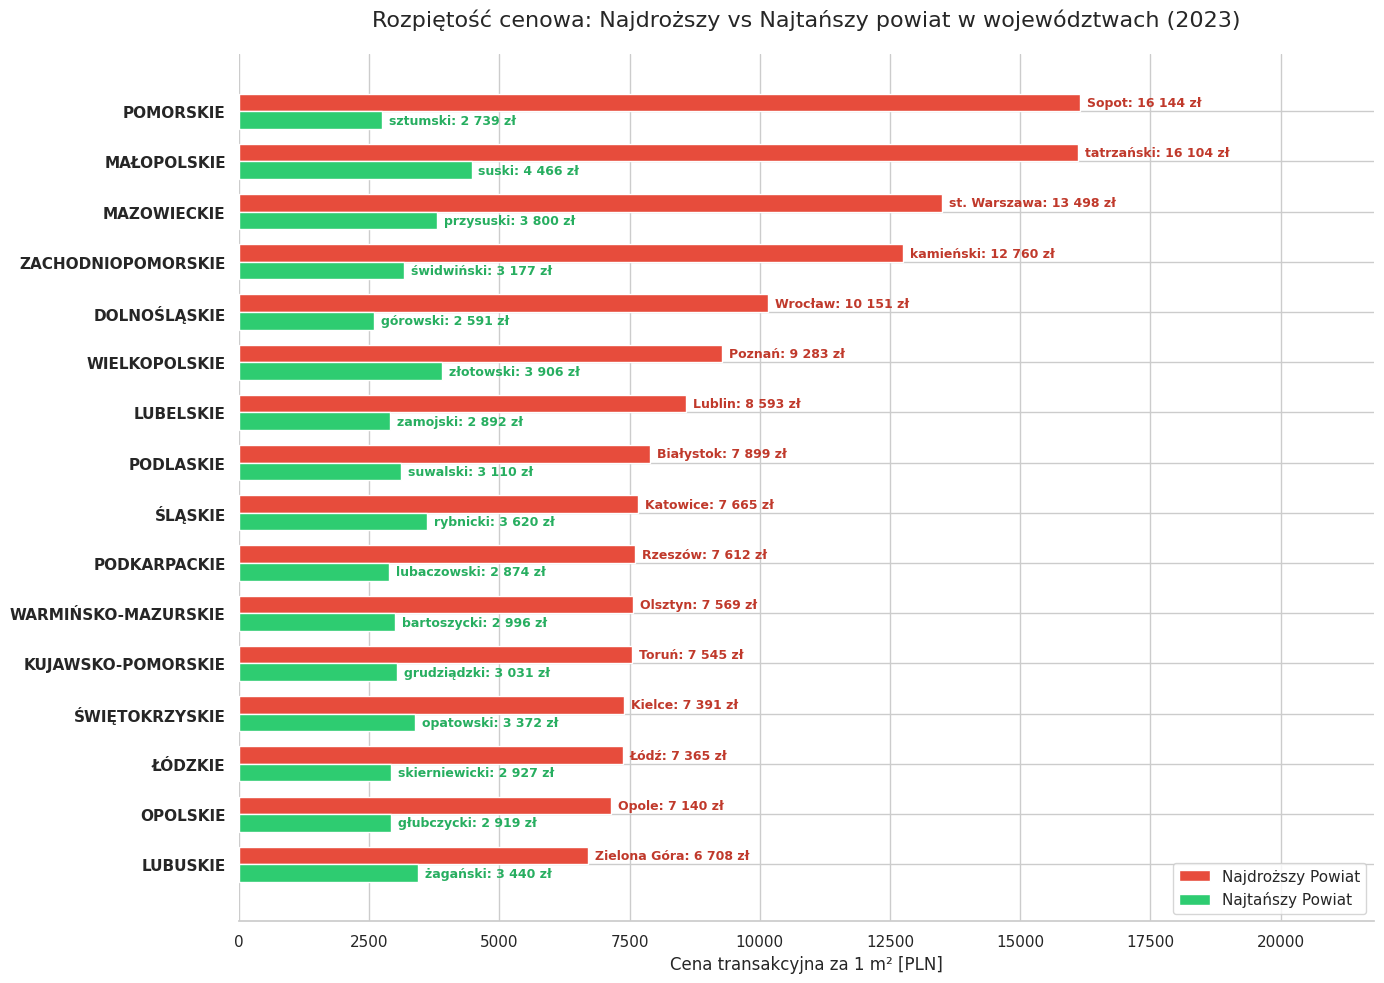

WNIOSKI: Wykres uwidacznia ogromne dysproporcje cenowe w ramach poszczególnych województw.
Widać, że nawet w obrębie tego samego regionu mogą występować znaczące różnice w cenach nieruchomości,
co jest istotne dla analizy rynku lokalnego i podejmowania decyzji inwestycyjnych. Na przykład, Mazowieckie ma zarówno jedne z najdroższych, jak i relatywnie drogie najtańsze powiaty w porównaniu do innych województw.
8. Sprawdzenie założeń do testów parametrycznych


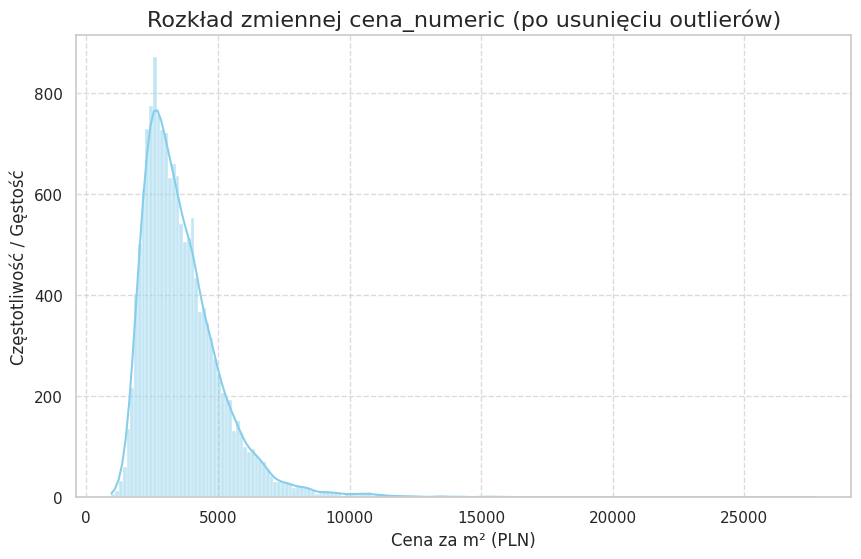

WNIOSKI: Mimo usunięcia wartości odstających, rozkład cen nieruchomości nadal wykazuje pewną asymetrię prawostronną
(jest 'ściągnięty' w lewo, z dłuższym ogonem w prawo), co jest typowe dla danych finansowych. Oznacza to, że większość nieruchomości ma niższe ceny, a mniejsza część – znacznie wyższe. Brak idealnej normalności sugeruje, że testy parametryczne mogą być mniej wiarygodne, dlatego zastosowano robust ANOVA.


<Figure size 800x600 with 0 Axes>

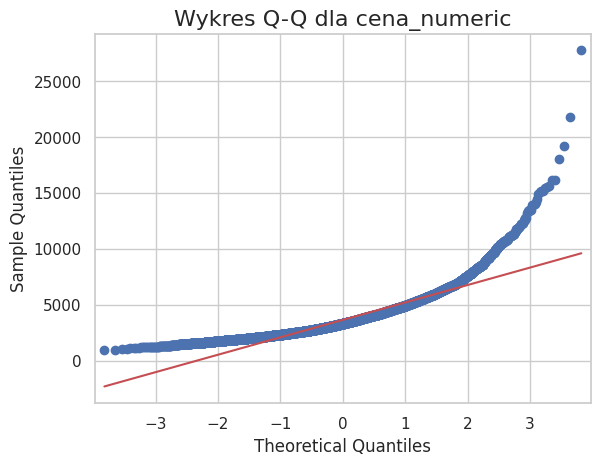

WNIOSKI: Punkty na wykresie Q-Q nie układają się idealnie wzdłuż linii prostej, szczególnie na krańcach rozkładu.
Potwierdza to wnioski z histogramu, że rozkład zmiennej 'cena_numeric' nie jest idealnie normalny. Odchylenia od linii oznaczają,
że w danych jest więcej skrajnych wartości, niż przewiduje rozkład normalny (cięższe ogony). Jest to ważne założenie dla wielu testów parametrycznych.

Test Shapiro-Wilka dla 'cena_numeric':
Statystyka testowa = 0.8537, p-wartość = 0.0000


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14996.
  res = hypotest_fun_out(*samples, **kwds)


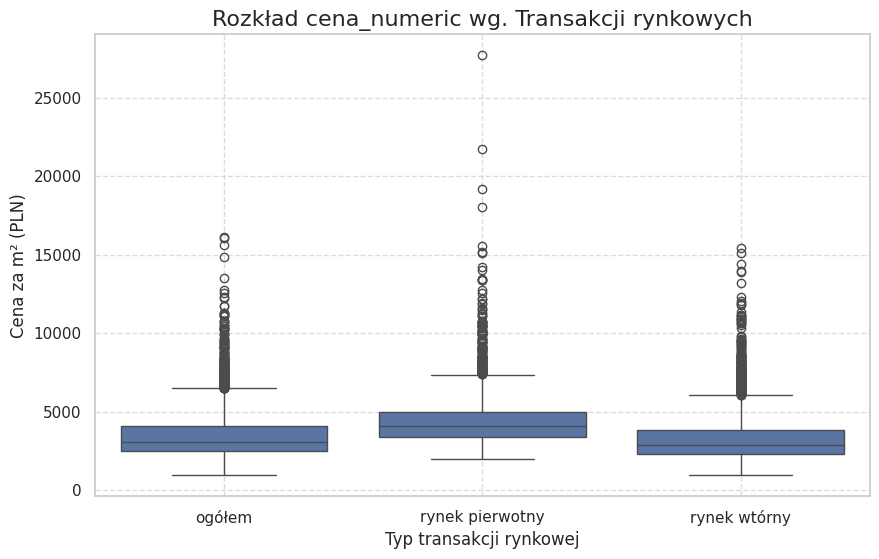

WNIOSKI: Można zauważyć, że szerokość pudełek i długość wąsów różnią się między grupami 'Transakcje rynkowe'.
To wizualnie sugeruje, że założenie o jednorodności wariancji może nie być spełnione. Wariancja cen na rynku pierwotnym wydaje się być większa niż na rynku wtórnym.


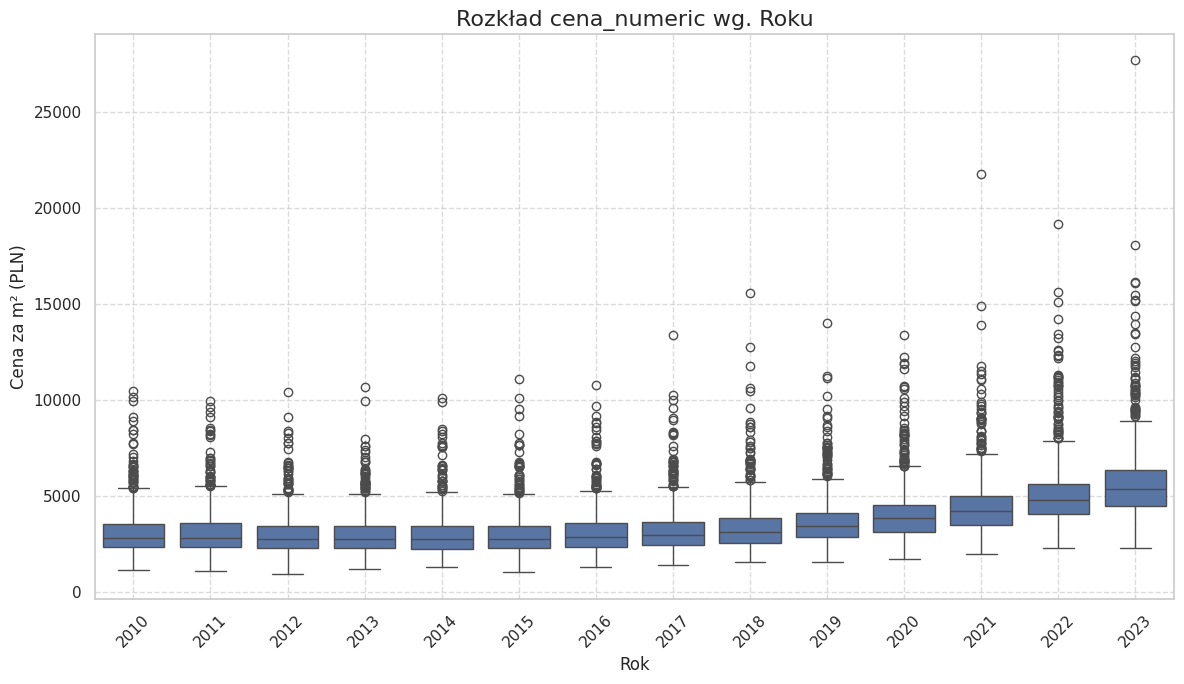

WNIOSKI: Wariancja cen nieruchomości znacząco wzrasta w kolejnych latach, co widać po coraz dłuższych pudełkach i wąsach w nowszych latach.
To wyraźne naruszenie założenia o jednorodności wariancji, co wzmacnia argument za użyciem testów odpornych na to założenie, takich jak Welch's ANOVA.


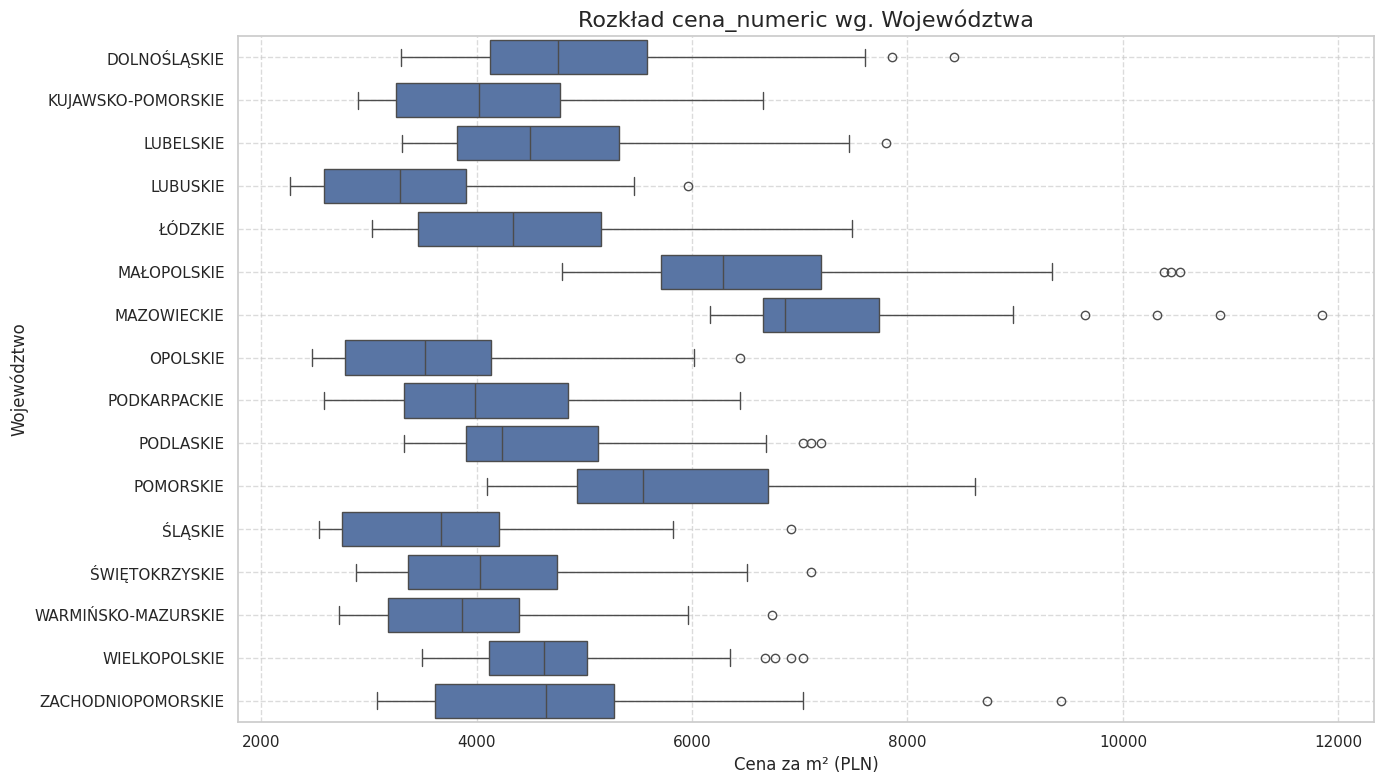

WNIOSKI: Wariancje cen również różnią się między województwami. Niektóre województwa (np. Mazowieckie, Małopolskie) mają szersze rozkłady cen,
co oznacza większą zmienność, podczas gdy inne (np. Lubuskie, Opolskie) mają bardziej zwarte rozkłady. Potwierdza to brak jednorodności wariancji również dla tego czynnika.

Test Levene'a dla 'Transakcje rynkowe':
Statystyka testowa = 6.5595, p-wartość = 0.0014

Test Levene'a dla 'Rok':
Statystyka testowa = 24.7711, p-wartość = 0.0000

Test Levene'a dla 'Nazwa' (województwa):
Statystyka testowa = 1.0528, p-wartość = 0.3983
### 9. Przeprowadzenie robust ANOVA (Welch's ANOVA) ###

--- Welch's ANOVA dla 'Transakcje rynkowe' ---
statistic = 734.1931526867207
pvalue = 4.1509726435591815e-297
df = (2.0, np.float64(9449.277878609888))
df_num = 2.0
df_denom = 9449.277878609888
nobs_t = 14996.0
n_groups = 3
means = [3451.76784731 4419.50987564 3261.26900477]
nobs = [5449. 4101. 5446.]
vars_ = [2144242.32733606 2494153.47045123 2022961.72064426]
use_var =

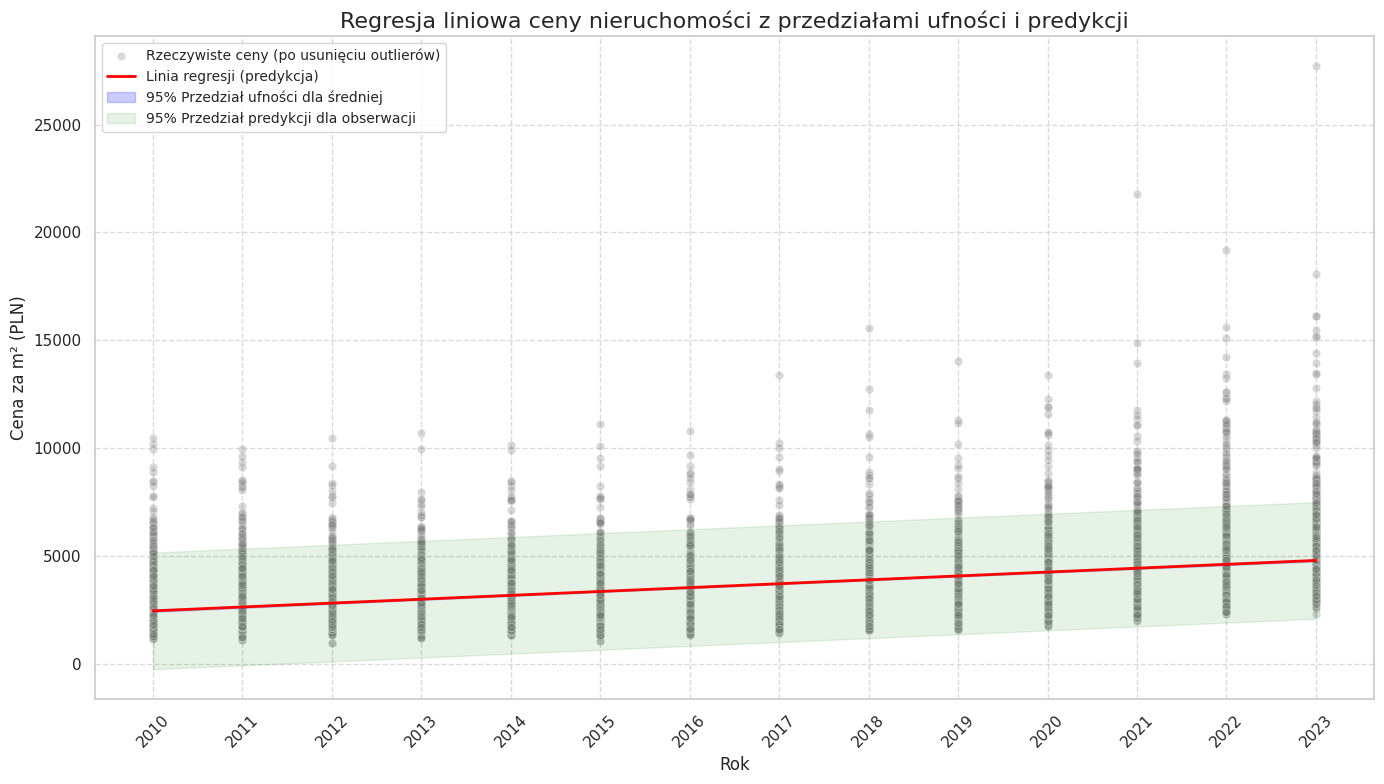

WNIOSKI: Model regresji liniowej wskazuje na silny i statystycznie istotny trend wzrostowy cen nieruchomości w czasie.
Przedział ufności dla średniej jest stosunkowo wąski, co świadczy o dobrej pewności co do przewidywanej średniej ceny dla danego roku.
Natomiast szerszy przedział predykcji dla pojedynczych obserwacji odzwierciedla naturalną zmienność cen poszczególnych nieruchomości,
co jest zgodne z obserwacją, że rynek jest złożony i na cenę wpływa wiele czynników poza samym rokiem.



# RAPORT KOŃCOWY: Analiza Rynku Nieruchomości w Polsce

## 1. Wstęp i przygotowanie danych
Celem analizy było zbadanie kształtowania się cen nieruchomości w Polsce z podziałem na rynek pierwotny i wtórny, w ujęciu czasowym oraz geograficznym.

**Kluczowe działania na danych:**
* **Czyszczenie:** Usunięto błędy formatowania (zamiana '-' na 0) oraz wyeliminowano rekordy z ceną 0.
* **Outliery:** Zastosowano metodę rozstępu ćwiartkowego (IQR), usuwając ekstremalne wartości cenowe, które mogłyby zniekształcić wyniki statystyczne (np. luksusowe apartamenty lub błędy wprowadzania danych).

---

## 2. Analiza Eksploracyjna (EDA) i Trendy

### A. Rynek Pierwotny vs Wtórny
* **Różnice cenowe:** Ceny na rynku pierwotnym są systematycznie wyższe niż na rynku wtórnym.
* **Zmienność:** Rynek pierwotny charakteryzuje się szerszym rozstępem cen (większa wariancja), co oznacza większe zróżnicowanie ofert deweloperskich w porównaniu do rynku wtórnego.
* **Rozkład:** Ceny wykazują asymetrię prawostronną – dominuje duża liczba transakcji tańszych i średnich, z "ogonem" w stronę wysokich cen.

### B. Trend czasowy
* Zidentyfikowano **silny, nieprzerwany trend wzrostowy** średnich cen za m².
* Dynamika wzrostu przyspieszyła w ostatnich latach, pogłębiając różnicę (spread) między rynkiem pierwotnym a wtórnym.

### C. Analiza Geograficzna (2023)
* **Liderzy:** Najdroższe województwa to Mazowieckie, Małopolskie i Pomorskie.
* **Rozwarstwienie:** Wewnątrz województw występują drastyczne dysproporcje cenowe. Różnica między najdroższym a najtańszym powiatem w tym samym regionie jest wielokrotna, co czyni średnią wojewódzką miarą mocno uogólnioną.

---

## 3. Wnioskowanie Statystyczne

### A. Weryfikacja założeń
Przed przystąpieniem do testów zweryfikowano założenia (istotne dla wiarygodności wyników):
* **Normalność rozkładu (Shapiro-Wilk):** Brak. Rozkłady są skośne.
* **Jednorodność wariancji (Levene):** Brak. Występuje heteroskedastyczność (wariancja rośnie wraz z upływem lat).

**Decyzja:** Zastosowano testy odporne (Robust statistics), w tym Welch's ANOVA, zamiast klasycznych metod.

### B. Wyniki Testów
1. **Test t-Studenta (pary):** Potwierdził istotną statystycznie różnicę między cenami na rynku pierwotnym a wtórnym.
2. **Welch's ANOVA:**
   * **Rok:** Czas jest istotnym czynnikiem różnicującym cenę.
   * **Rynek:** Typ transakcji istotnie wpływa na cenę.
   * **Województwo:** Lokalizacja jest kluczowym determinantem ceny.

---

## 4. Modelowanie (Regresja Liniowa)

Zbudowano model regresji liniowej (`OLS`), przewidujący cenę na podstawie roku.

**Interpretacja Modelu:**
* **Trend:** Współczynnik kierunkowy jest dodatni i istotny statystycznie – potwierdza matematycznie wzrost cen.
* **Przedziały Ufności (Wąskie):** Mamy wysoką pewność co do oszacowania *średniej* ceny w danym roku.
* **Przedziały Predykcji (Szerokie):** Model oparty tylko na roku nie jest wystarczający do wyceny *pojedynczego* mieszkania, ze względu na dużą zmienność naturalną rynku (lokalizacja, standard).

---

## 5. Podsumowanie Menedżerskie
Analiza potwierdza stabilny wzrost wartości nieruchomości w Polsce. Rynek staje się jednak coraz bardziej złożony – wraz ze wzrostem cen rośnie ich zmienność (ryzyko).
Decyzje inwestycyjne powinny uwzględniać nie tylko średnie ceny dla województw, ale przede wszystkim specyfikę lokalną (poziom powiatu), gdzie różnice cenowe są najbardziej drastyczne.


In [12]:
import pandas as pd
import numpy as np
import requests
import io
import seaborn as sns
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.oneway import anova_oneway
from IPython.display import display, Markdown
import os


# 1. Ładowanie danych
# Pobieranie pliku z GitHub
github_excel_url = 'https://raw.githubusercontent.com/MatiMajewski/Beginners/refs/heads/main/RYNEK_NIER.xlsx'
response = requests.get(github_excel_url)
df_org = pd.read_excel(io.BytesIO(response.content), header=0)

df = df_org.copy()

# 2. Czyszczenie danych
# Diagnostyka struktury
print("--- INFO O STRUKTURZE ---")
print(df.info())

# Liczenie '-'
num_hyphens = df['Wartosc'].astype(str).str.contains('-').sum()
print(f"\nLiczba wartości z '-' w kolumnie 'Wartosc': {num_hyphens}")

# Konwersja wartości na typ numeryczny.
df['Wartosc'] = df['Wartosc'].astype(str).str.replace('-', '0', regex=False) # Zmiana: zamiana '-' na '0'
df['cena_numeric'] = pd.to_numeric(df['Wartosc'], errors='coerce')

# Usunięcie wierszy z brakującymi wartościami w 'cena_numeric' i przypisanie do df_clean
df_clean = df.dropna(subset=['cena_numeric'])

# Sprawdzenie braków i unikalnych wartości
print("\n--- BRAKI W DANYCH ---")
print(df.isnull().sum())

# Sprawdzanie wartości 0 w kolumnie 'Wartosc'
zero_price_rows = df_clean[df_clean['cena_numeric'] == 0]
zero_counts_by_market = zero_price_rows.groupby('Transakcje rynkowe').size().reset_index(name='Liczba_zerowych_cen')

print("Liczba zerowych cen w podziale na typ transakcji rynkowej:")
display(zero_counts_by_market)

# Usuwamy wiersze z wartościami 0
initial_rows_in_df_clean = len(df_clean)
df_clean = df_clean[df_clean['cena_numeric'] != 0].copy()
print("------------------------------------------------------------")
print(f"Liczba wierszy w df_clean przed usunięciem zer: {initial_rows_in_df_clean}")
print(f"Liczba wierszy w df_clean po usunięciu zer: {len(df_clean)}")

print("------------------------------------------------------------")
print("\n--- WARTOŚCI W KOLUMNIE GRUPUJĄCEJ ---")
# Sprawdzamy, czy 'rynek pierwotny' nie jest zapisany na 3 różne sposoby (np. z literówkami)
print(df['Transakcje rynkowe'].unique())



# 3. Statystyki opisowe i usuwanie outlierów
# Statystyki opisowe
stats_desc = df_clean.groupby('Transakcje rynkowe')['cena_numeric'].describe().round(2)
print("------------------------------------------------------------")
display(stats_desc)

# Wizualizacja rozkładu z ekstremami
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='Transakcje rynkowe', y='cena_numeric')
plt.title("Porównanie cen nieruchomości wg typu transakcji")
plt.xlabel("Typ transakcji rynkowej")
plt.ylabel("Cena za m² (PLN)")
plt.show()
print("WNIOSKI: Można zauważyć znaczną liczbę outlierów, szczególnie w rynku ogółem i rynku wtórnym,")
print("co sugeruje potrzebę dalszego czyszczenia danych w celu dokładniejszej analizy.")

# Obliczanie Q1, Q3 i IQR do usuwania outlierów z df_clean
Q1 = df_clean['cena_numeric'].quantile(0.15)
Q3 = df_clean['cena_numeric'].quantile(0.85)
IQR = Q3 - Q1

# Definiowanie granic dla outlierów
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filtrowanie outlierów i przypisanie do df_outliers, aby uwzględnić wszystkie typy rynkowe, w tym 'ogółem'
df_outliers = df_clean[(df_clean['cena_numeric'] >= lower_bound) & (df_clean['cena_numeric'] <= upper_bound)].copy()

# Statystyki opisowe
stats_desc = df_outliers.groupby('Transakcje rynkowe')['cena_numeric'].describe().round(2)
print("------------------------------------------------------------")
display(stats_desc)

# Wizualizacja rozkładu
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_outliers, x='Transakcje rynkowe', y='cena_numeric')
plt.title("Porównanie cen nieruchomości wg typu transakcji (po usunięciu outlierów)")
plt.xlabel("Typ transakcji rynkowej")
plt.ylabel("Cena za m² (PLN)")
plt.show()
print("WNIOSKI: Po usunięciu outlierów rozkład cen stał się bardziej jednorodny, a mediany cen dla różnych typów transakcji są wyraźniej widoczne,")
print("Rynek pierwotny wykazuje zazwyczaj wyższe ceny niż rynek wtórny, z rynkiem ogółem plasującym się gdzieś pomiędzy.")

print("------------------------------------------------------------")

# 4. Wizualizacja rozkładu danych
# Porównanie rozkładu cen bez ekstremów
# Ustawienie estetyki wykresów
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

# Generowanie histogramu z krzywą gęstości (KDE)
# Teraz uwzględniamy wszystkie typy transakcji rynkowych
plot_data = df_clean

sns.histplot(
    data=plot_data,
    x='cena_numeric',
    hue='Transakcje rynkowe',
    kde=True,
    element="step",
    palette='magma',
    alpha=0.4
)

plt.title('Porównanie rozkładów cen: Rynek Pierwotny, Wtórny i Ogółem', fontsize=15)
plt.xlabel('Cena za m² (PLN)', fontsize=12)
plt.ylabel('Częstotliwość / Gęstość', fontsize=12)

# legenda dla wszystkich trzech kategorii
plt.legend(title='Typ rynku', labels=['Rynek Wtórny', 'Rynek Pierwotny', 'Ogółem'])

plt.show()
print("WNIOSKI: Rozkłady cen na poszczególnych rynkach są zróżnicowane. Rynek pierwotny ma tendencję do wyższych cen i bardziej rozproszonego rozkładu niż rynek wtórny.")
print("Rozkład ogólny jest wypadkową tych dwóch, ale nadal charakteryzuje się asymetrią prawostronną, co wskazuje na dominację niższych cen z dłuższym ogonem w stronę wyższych wartości.")

print("------------------------------------------------------------")

# Wykres liniowy cen w latach dla polski na rynku ogółem
df_polska = df_clean[
    (df_clean['Nazwa'] == 'POLSKA') &
    (df_clean['Transakcje rynkowe'] == 'ogółem')
].copy()

prices_polska_yearly = df_polska.groupby('Rok')['cena_numeric'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=prices_polska_yearly, x='Rok', y='cena_numeric', marker='o')
plt.title('Średnie Ceny Nieruchomości w Polsce na przestrzeni lat (ogółem)', fontsize=16)
plt.xlabel('Rok', fontsize=12)
plt.ylabel('Średnia Cena za m² (PLN)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(prices_polska_yearly['Rok'].unique(), rotation=45)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()
print("WNIOSKI: Wykres pokazuje wyraźny trend wzrostowy średnich cen nieruchomości w Polsce w badanym okresie,")
print("co sugeruje rosnącą wartość nieruchomości w kraju. Szczególnie silny wzrost jest widoczny w ostatnich latach.")

print("------------------------------------------------------------")

# Wykres liniowy cen w latach dla polski dla rynku pierwotnego i wtórnego
df_polska_markets = df_clean[
    (df_clean['Nazwa'] == 'POLSKA') &
    (df_clean['Transakcje rynkowe'].isin(['rynek pierwotny', 'rynek wtórny']))
].copy()

prices_polska_yearly_markets = df_polska_markets.groupby(['Rok', 'Transakcje rynkowe'])['cena_numeric'].mean().reset_index()
print("------------------------------------------------------------")
plt.figure(figsize=(12, 6))
sns.lineplot(data=prices_polska_yearly_markets, x='Rok', y='cena_numeric', hue='Transakcje rynkowe', marker='o')
plt.title('Średnie Ceny Nieruchomości w Polsce (rynek pierwotny i wtórny)', fontsize=16)
plt.xlabel('Rok', fontsize=12)
plt.ylabel('Średnia Cena za m² (PLN)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(prices_polska_yearly_markets['Rok'].unique(), rotation=45)
plt.legend(title='Typ rynku')
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()
print("WNIOSKI: Ceny na rynku pierwotnym są konsekwentnie wyższe niż na rynku wtórnym przez cały analizowany okres.")
print("Obie linie pokazują trend wzrostowy, ale rynek pierwotny wykazuje szybszy wzrost w ostatnich latach, co może świadczyć o większym zapotrzebowaniu na nowe mieszkania lub wyższych kosztach budowy.")
print("------------------------------------------------------------")

# Siatka wykresów: zmiana % względem pierwszego roku dla każdego województwa (rynek pierwotny)

# Siatka wykresów: zmiana % względem pierwszego roku dla każdego województwa (rynek pierwotny)
import math
import matplotlib.pyplot as plt


voiv = df.copy()

voiv["Rok"] = pd.to_numeric(voiv["Rok"], errors="coerce")
voiv["Wartosc"] = pd.to_numeric(voiv["Wartosc"], errors="coerce")
voiv = voiv.dropna(subset=["Rok", "Wartosc"])
voiv = voiv[voiv["Transakcje rynkowe"].str.contains("rynek pierwotny", case=False, na=False)]
voiv = voiv[~voiv["Nazwa"].str.contains("POLSKA|powiat|gmina", case=False, na=False)]

pct_rows = []
for name, wo in voiv.groupby("Nazwa"):
    wo = wo.sort_values("Rok")
    # Ensure the base value is not 0 or NaN before division
    base = wo.iloc[0]["Wartosc"]
    if pd.isna(base) or base == 0:
        # If base is problematic, assign NA for pct_vs_first or skip segment
        pct_rows.append(wo.assign(pct_vs_first=pd.NA))
        print(f"Ostrzeżenie: Pierwsza wartość dla segmentu '{name}' wynosi 0 lub NaN. Nie można obliczyć zmiany procentowej.")
    else:
        pct_rows.append(wo.assign(pct_vs_first=(wo["Wartosc"] / base - 1) * 100))

if not pct_rows:
    raise ValueError("Brak danych do wygenerowania zmian procentowych po grupowaniu i czyszczeniu.")
voiv_pct = pd.concat(pct_rows, ignore_index=True)

# Drop rows where pct_vs_first might be NA due to problematic base values
voiv_pct = voiv_pct.dropna(subset=["pct_vs_first"])

names = sorted(voiv_pct["Nazwa"].unique())
n = len(names)
cols = 4
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(16, 3.2 * rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, name in enumerate(names):
    ax = axes[i]
    wo = voiv_pct[voiv_pct["Nazwa"] == name]
    if wo.empty:
        ax.text(0.5, 0.5, "Brak danych", ha="center", va="center", transform=ax.transAxes)
    else:
        ax.plot(wo["Rok"], wo["pct_vs_first"], marker="o", linewidth=1.2, alpha=0.9)
    ax.set_title(name)
    ax.grid(True, linestyle=":", alpha=0.5)
    if i % cols == 0:
        ax.set_ylabel("Zmiana [%]")
    if i // cols == rows - 1:
        ax.set_xlabel("Rok")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()
print("WNIOSKI: Wykresy te pozwalają na porównanie dynamiki zmian cen w różnych województwach. Można zauważyć, że niektóre regiony doświadczyły znacznie większych wzrostów cen niż inne,")
print("co może być związane z lokalnymi czynnikami ekonomicznymi i demograficznymi. Niektóre województwa wykazują stabilniejszy wzrost, podczas gdy inne miały bardziej zmienny rozwój.")


print("------------------------------------------------------------")

voivodeships = [
    'DOLNOŚLĄSKIE', 'KUJAWSKO-POMORSKIE', 'LUBELSKIE', 'LUBUSKIE',
    'ŁÓDZKIE', 'MAŁOPOLSKIE', 'MAZOWIECKIE', 'OPOLSKIE', 'PODKARPACKIE',
    'PODLASKIE', 'POMORSKIE', 'ŚLĄSKIE', 'ŚWIĘTOKRZYSKIE',
    'WARMIŃSKO-MAZURSKIE', 'WIELKOPOLSKIE', 'ZACHODNIOPOMORSKIE'
]

df_voivodeships = df_clean[df_clean['Nazwa'].isin(voivodeships)]
average_prices_by_voivodeship = df_voivodeships.groupby('Nazwa')['cena_numeric'].mean().reset_index()

styled_table = average_prices_by_voivodeship.style\
    .background_gradient(cmap='Greens', subset=['cena_numeric']) \
    .set_properties(**{'border-color': '#0a0a0a', 'border-style': 'solid', 'border-width': '1px'}) \
    .set_table_styles([{'selector': 'td, th', 'props': [('border', '1px solid #0a0a0a')]}])

print("Średnie ceny nieruchomości dla województw")
display(styled_table)

df_processed = df.copy()

df_processed.rename(columns={'Nazwa': 'Region', 'Transakcje rynkowe': 'Market', 'Rok': 'Year', 'Wartosc': 'Price'}, inplace=True)

df_processed['Price'] = pd.to_numeric(df_processed['Price'], errors='coerce')
df_processed = df_processed[df_processed['Price'] > 0]


# Analiza danych eksploracyjna (EDA) dla 2023 i województw
latest_year = 2023
df_2023 = df_processed[(df_processed['Region'].isin(voivodeships)) & (df_processed['Year'] == latest_year)].copy()

# Tabela podsumowująca
summary_pivot = df_2023.pivot(index='Region', columns='Market', values='Price')
summary_pivot['Różnica (P-W)'] = summary_pivot['rynek pierwotny'] - summary_pivot['rynek wtórny']
summary_pivot = summary_pivot.sort_values(by='rynek pierwotny', ascending=False)
summary_pivot.to_csv('porownanie_wojewodztw_2023.csv')

# Wizualizacja dla 2023
plt.figure(figsize=(14, 8))
df_plot = df_2023.sort_values(by='Price', ascending=False)
sns.barplot(data=df_plot, y='Region', x='Price', hue='Market', palette='muted')
plt.title(f'Porównanie cen mieszkań w województwach (rok {latest_year})', fontsize=16)
plt.xlabel('Cena za 1 m2 (PLN)', fontsize=12)
plt.ylabel('Województwo', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.savefig('ceny_wojewodztwa_2023.png')
plt.show()
print(f"WNIOSKI: Wykres jasno pokazuje różnice w cenach mieszkań między rynkiem pierwotnym a wtórnym w poszczególnych województwach.")
print("Widać, że niektóre województwa, takie jak Mazowieckie i Małopolskie, mają znacznie wyższe ceny ogółem, co jest zgodne z ich statusem gospodarczym i demograficznym.")
print("Różnica między rynkiem pierwotnym a wtórnym jest różna w zależności od regionu, co może wskazywać na lokalne dynamiki podaży i popytu.")

# 5. Inferencja statystyczna (Test t-studenta i przedział ufności)
# Test t-studenta dla par: Czy różnica między rynkiem pierwotnym a wtórnym jest istotna w województwach?
p_market = summary_pivot['rynek pierwotny']
w_market = summary_pivot['rynek wtórny']
t_stat, p_val = stats.ttest_rel(p_market, w_market)

# Przedział ufności dla średniej ceny (wszystkie obserwacje w 2023 r.)
mean_val = df_2023['Price'].mean()
sem_val = stats.sem(df_2023['Price'])
conf_int = stats.t.interval(0.95, len(df_2023['Price'])-1, loc=mean_val, scale=sem_val)

print("Summary Table:")
print(summary_pivot)
print(f"\nStatistical Results for {latest_year}:")
print(f"Mean Price (Voivodeships): {mean_val:.2f} PLN")
print(f"95% CI: {conf_int}")
print(f"Paired t-test (P vs W): t={t_stat:.4f}, p={p_val:.4f}")

# Analiza najdroższych i najtańszych powiatów w 2023

df['Wartosc'] = df['Wartosc'].astype(str).str.replace(' ', '')
df['Wartosc'] = pd.to_numeric(df['Wartosc'].replace('-', np.nan), errors='coerce')

print("------------------------------------------------------------")
df['Wojewodztwo'] = df['Nazwa'].apply(lambda x: x if x in voivodeships else np.nan).ffill()
mask = (
    (df['Rok'] == 2023) &
    (df['Transakcje rynkowe'] == 'ogółem') &
    (~df['Nazwa'].isin(voivodeships)) &  # Odrzucamy wiersze zbiorcze dla woj.
    (df['Nazwa'] != 'POLSKA') &              # Odrzucamy Polskę
    (df['Nazwa'].str.contains('Powiat', na=False)) # Zostawiamy tylko powiaty
)
df_2023 = df[mask].copy()

# MAX MIN
wyniki = []

for woj in df_2023['Wojewodztwo'].unique():
    grupa = df_2023[df_2023['Wojewodztwo'] == woj]
    if grupa.empty: continue

    najdrozszy = grupa.loc[grupa['Wartosc'].idxmax()]
    najtanszy = grupa.loc[grupa['Wartosc'].idxmin()]

    wyniki.append({
        'Województwo': woj,
        'Najdroższy Powiat': najdrozszy['Nazwa'],
        'Cena Max [zł/m2]': najdrozszy['Wartosc'],
        'Najtańszy Powiat': najtanszy['Nazwa'],
        'Cena Min [zł/m2]': najtanszy['Wartosc']
    })

df_wynik = pd.DataFrame(wyniki)
display(df_wynik)

print("------------------------------------------------------------")


# Konwersja kolumn na typ numeryczny przed sortowaniem i innymi operacjami
df_wynik['Cena Max [zł/m2]'] = pd.to_numeric(df_wynik['Cena Max [zł/m2]'])
df_wynik['Cena Min [zł/m2]'] = pd.to_numeric(df_wynik['Cena Min [zł/m2]'])

# Sortujemy dane, żeby wykres był czytelny (od najdroższego województwa)
df_plot = df_wynik.sort_values('Cena Max [zł/m2]', ascending=True)

# Ustawienia stylu
sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif'

# Tworzenie figury
fig, ax = plt.subplots(figsize=(14, 10))

# Parametry słupków
y = np.arange(len(df_plot))
height = 0.35

# Słupki MAX (Czerwone - najdroższe)
rects_max = ax.barh(y + height/2, df_plot['Cena Max [zł/m2]'], height,
                    label='Najdroższy Powiat', color='#e74c3c', edgecolor='white')

# Słupki MIN (Zielone - najtańsze)
# Przesuwamy je o połowę wysokości w dół (-height/2)
rects_min = ax.barh(y - height/2, df_plot['Cena Min [zł/m2]'], height,
                    label='Najtańszy Powiat', color='#2ecc71', edgecolor='white')

# --- Dodawanie Etykiet (Wartości liczbowe) ---
def dodaj_etykiety(rects, nazwy_powiatow, kolor):
    for rect, nazwa in zip(rects, nazwy_powiatow):
        width = rect.get_width()

        # Formatowanie tekstu: "Nazwa: 10 000 zł"
        # Usuwamy "Powiat " z nazwy, żeby było czytelniej
        nazwa_krotka = nazwa.replace('Powiat ', '').replace('m. ', '')
        label_text = f'{nazwa_krotka}: {int(width):,} zł'.replace(',', ' ')

        ax.annotate(label_text,
                    xy=(width, rect.get_y() + rect.get_height() / 2),
                    xytext=(5, 0),  # Przesunięcie tekstu o 5 pkt w prawo
                    textcoords="offset points",
                    ha='left', va='center',
                    fontsize=9, fontweight='bold', color=kolor)

# Wywołanie funkcji etykietowania
dodaj_etykiety(rects_max, df_plot['Najdroższy Powiat'], '#c0392b') # Ciemnoczerwony
dodaj_etykiety(rects_min, df_plot['Najtańszy Powiat'], '#27ae60') # Ciemnozielony

ax.set_yticks(y)
ax.set_yticklabels(df_plot['Województwo'], fontsize=11, fontweight='bold')
ax.set_xlabel('Cena transakcyjna za 1 m² [PLN]', fontsize=12)
ax.set_title('Rozpiętość cenowa: Najdroższy vs Najtańszy powiat w województwach (2023)',
             fontsize=16, pad=20)
ax.legend(loc='lower right', frameon=True)

# Usunięcie zbędnych ramek (góra, prawo, lewo)
sns.despine(left=True, bottom=False)

# Rozszerzenie osi X, żeby zmieściły się długie napisy po prawej stronie
ax.set_xlim(0, df_plot['Cena Max [zł/m2]'].max() * 1.35)

plt.tight_layout()
plt.show()
print("WNIOSKI: Wykres uwidacznia ogromne dysproporcje cenowe w ramach poszczególnych województw.")
print("Widać, że nawet w obrębie tego samego regionu mogą występować znaczące różnice w cenach nieruchomości,")
print("co jest istotne dla analizy rynku lokalnego i podejmowania decyzji inwestycyjnych. Na przykład, Mazowieckie ma zarówno jedne z najdroższych, jak i relatywnie drogie najtańsze powiaty w porównaniu do innych województw.")

print("8. Sprawdzenie założeń do testów parametrycznych")

# Wizualna ocena normalności: Histogram z KDE
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['cena_numeric'], kde=True, color='skyblue')
plt.title('Rozkład zmiennej cena_numeric', fontsize=16)
plt.xlabel('Cena za m² (PLN)', fontsize=12)
plt.ylabel('Częstotliwość / Gęstość', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print("WNIOSKI: Mimo usunięcia wartości odstających, rozkład cen nieruchomości nadal wykazuje pewną asymetrię prawostronną")
print("(jest 'ściągnięty' w lewo, z dłuższym ogonem w prawo), co jest typowe dla danych finansowych. Oznacza to, że większość nieruchomości ma niższe ceny, a mniejsza część – znacznie wyższe. Brak idealnej normalności sugeruje, że testy parametryczne mogą być mniej wiarygodne, dlatego zastosowano robust ANOVA.")

# Wykres Q-Q

plt.figure(figsize=(8, 6))
sm.qqplot(df_clean['cena_numeric'], line='s')
plt.title('Wykres Q-Q dla cena_numeric', fontsize=16)
plt.show()
print("WNIOSKI: Punkty na wykresie Q-Q nie układają się idealnie wzdłuż linii prostej, szczególnie na krańcach rozkładu.")
print("Potwierdza to wnioski z histogramu, że rozkład zmiennej 'cena_numeric' nie jest idealnie normalny. Odchylenia od linii oznaczają,")
print("że w danych jest więcej skrajnych wartości, niż przewiduje rozkład normalny (cięższe ogony). Jest to ważne założenie dla wielu testów parametrycznych.")

# Test Shapiro-Wilka na normalność
shapiro_test = stats.shapiro(df_clean['cena_numeric'])
print(f"\nTest Shapiro-Wilka dla 'cena_numeric':\nStatystyka testowa = {shapiro_test.statistic:.4f}, p-wartość = {shapiro_test.pvalue:.4f}")

# Wizualna ocena jednorodności wariancji: Wykresy pudełkowe
plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='Transakcje rynkowe', y='cena_numeric')
plt.title('Rozkład cena_numeric wg. Transakcji rynkowych', fontsize=16)
plt.xlabel('Typ transakcji rynkowej', fontsize=12)
plt.ylabel('Cena za m² (PLN)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.show()
print("WNIOSKI: Można zauważyć, że szerokość pudełek i długość wąsów różnią się między grupami 'Transakcje rynkowe'.")
print("To wizualnie sugeruje, że założenie o jednorodności wariancji może nie być spełnione. Wariancja cen na rynku pierwotnym wydaje się być większa niż na rynku wtórnym.")

# Rok
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_clean, x='Rok', y='cena_numeric')
plt.title('Rozkład cena_numeric wg. Roku', fontsize=16)
plt.xlabel('Rok', fontsize=12)
plt.ylabel('Cena za m² (PLN)', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print("WNIOSKI: Wariancja cen nieruchomości znacząco wzrasta w kolejnych latach, co widać po coraz dłuższych pudełkach i wąsach w nowszych latach.")
print("To wyraźne naruszenie założenia o jednorodności wariancji, co wzmacnia argument za użyciem testów odpornych na to założenie, takich jak Welch's ANOVA.")

# 'Nazwa' (dla wybranej liczby, np. top 10 lub losowych)
# Ze względu na dużą liczbę unikalnych nazw, weźmiemy tylko najczęstsze lub wybrane,
# aby wykres był czytelny. Tutaj wybierzemy wszystkie województwa z wcześniejszej listy.
df_voivodeships_outliers = df_clean[df_clean['Nazwa'].isin(voivodeships)].copy()
if not df_voivodeships_outliers.empty:
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df_voivodeships_outliers, x='cena_numeric', y='Nazwa')
    plt.title('Rozkład cena_numeric wg. Województwa', fontsize=16)
    plt.xlabel('Cena za m² (PLN)', fontsize=12)
    plt.ylabel('Województwo', fontsize=12)
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()
    print("WNIOSKI: Wariancje cen również różnią się między województwami. Niektóre województwa (np. Mazowieckie, Małopolskie) mają szersze rozkłady cen,")
    print("co oznacza większą zmienność, podczas gdy inne (np. Lubuskie, Opolskie) mają bardziej zwarte rozkłady. Potwierdza to brak jednorodności wariancji również dla tego czynnika.")
else:
    print("Brak danych dla województw w df_clean do wygenerowania boxplotu dla 'Nazwa'.")

# Test Levene'a na jednorodność wariancji

groups_market = [df_clean['cena_numeric'][df_clean['Transakcje rynkowe'] == cat] for cat in df_clean['Transakcje rynkowe'].unique()]
levene_market = stats.levene(*groups_market)
print(f"\nTest Levene'a dla 'Transakcje rynkowe':\nStatystyka testowa = {levene_market.statistic:.4f}, p-wartość = {levene_market.pvalue:.4f}")


groups_rok = [df_clean['cena_numeric'][df_clean['Rok'] == r] for r in df_clean['Rok'].unique()]
levene_rok = stats.levene(*groups_rok)
print(f"\nTest Levene'a dla 'Rok':\nStatystyka testowa = {levene_rok.statistic:.4f}, p-wartość = {levene_rok.pvalue:.4f}")

# Nazwa (dla województw)
if not df_voivodeships_outliers.empty:
    groups_nazwa = [df_voivodeships_outliers['cena_numeric'][df_voivodeships_outliers['Nazwa'] == n] for n in df_voivodeships_outliers['Nazwa'].unique()]
    levene_nazwa = stats.levene(*groups_nazwa)
    print(f"\nTest Levene'a dla 'Nazwa' (województwa):\nStatystyka testowa = {levene_nazwa.statistic:.4f}, p-wartość = {levene_nazwa.pvalue:.4f}")
else:
    print("Brak danych dla województw w df_clean do przeprowadzenia testu Levene'a dla 'Nazwa'.")


print("### 9. Przeprowadzenie robust ANOVA (Welch's ANOVA) ###")

#  Welch's ANOVA dla 'Transakcje rynkowe'
print("\n--- Welch's ANOVA dla 'Transakcje rynkowe' ---")
groups_market_welch = [df_clean['cena_numeric'][df_clean['Transakcje rynkowe'] == cat] for cat in df_clean['Transakcje rynkowe'].unique()]
anova_market = anova_oneway(groups_market_welch, use_var='unequal')
print(anova_market)

# Welch's ANOVA dla 'Rok'
print("\n--- Welch's ANOVA dla 'Rok' ---")
groups_rok_welch = [df_clean['cena_numeric'][df_clean['Rok'] == r] for r in df_clean['Rok'].unique()]
anova_rok = anova_oneway(groups_rok_welch, use_var='unequal')
print(anova_rok)

# Welch's ANOVA dla 'Nazwa' (województwa)
print("\n--- Welch's ANOVA dla 'Nazwa' (województwa) ---")
if not df_voivodeships_outliers.empty:
    groups_nazwa_welch = [df_voivodeships_outliers['cena_numeric'][df_voivodeships_outliers['Nazwa'] == n] for n in df_voivodeships_outliers['Nazwa'].unique()]
    anova_nazwa = anova_oneway(groups_nazwa_welch, use_var='unequal')
    print(anova_nazwa)
else:
    print("Brak danych dla województw w df_clean do przeprowadzenia Welch's ANOVA dla 'Nazwa'.")


print(" Budowa i ocena prostego modelu regresji liniowej")

# Tworzenie modelu regresji liniowej
# Model przewiduje 'cena_numeric' na podstawie 'Rok'
model = smf.ols('cena_numeric ~ Rok', data=df_clean)

# Dopasowanie modelu do danych
results = model.fit()

# Wyświetlenie podsumowania modelu
print(results.summary())


print("Obliczenie i wizualizacja przedziałów predykcji")

# zakres lat
# Min max
min_rok = df_clean['Rok'].min()
max_rok = df_clean['Rok'].max()

# lata do predykcji, np. od min_rok do max_rok
pred_years = pd.DataFrame({'Rok': np.arange(min_rok, max_rok + 1)})

# metoda .get_prediction() na obiekcie results
predictions = results.get_prediction(pred_years)

# wartości przewidywane i przedziały
pred_summary = predictions.summary_frame(alpha=0.05) # alpha=0.05 dla 95% przedziałów

# Przygotowanie danych do wizualizacji
pred_years_data = pred_years['Rok']
predicted_mean = pred_summary['mean']
# Przedział ufności dla średniej
mean_ci_lower = pred_summary['mean_ci_lower']
mean_ci_upper = pred_summary['mean_ci_upper']
# Przedział predykcji dla pojedynczych obserwacji
obs_ci_lower = pred_summary['obs_ci_lower']
obs_ci_upper = pred_summary['obs_ci_upper']

# wykres punktowy rozrzutu zmiennej cena_numeric względem Rok z df_clean.
plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_clean, x='Rok', y='cena_numeric', alpha=0.3, label='Rzeczywiste ceny', color='gray')

# linia regresji
plt.plot(pred_years_data, predicted_mean, color='red', linewidth=2, label='Linia regresji (predykcja)')

# przedział ufności
plt.fill_between(pred_years_data, mean_ci_lower, mean_ci_upper, color='blue', alpha=0.2, label='95% Przedział ufności dla średniej')

# przedział predykcji
plt.fill_between(pred_years_data, obs_ci_lower, obs_ci_upper, color='green', alpha=0.1, label='95% Przedział predykcji dla obserwacji')

# tytuł wykresu, etykiety osi oraz legenda
plt.title('Regresja liniowa ceny nieruchomości z przedziałami ufności i predykcji', fontsize=16)
plt.xlabel('Rok', fontsize=12)
plt.ylabel('Cena za m² (PLN)', fontsize=12)
plt.xticks(pred_years_data.unique(), rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=10)
plt.tight_layout()
plt.show()
print("WNIOSKI: Model regresji liniowej wskazuje na silny i statystycznie istotny trend wzrostowy cen nieruchomości w czasie.")
print("Przedział ufności dla średniej jest stosunkowo wąski, co świadczy o dobrej pewności co do przewidywanej średniej ceny dla danego roku.")
print("Natomiast szerszy przedział predykcji dla pojedynczych obserwacji odzwierciedla naturalną zmienność cen poszczególnych nieruchomości,")
print("co jest zgodne z obserwacją, że rynek jest złożony i na cenę wpływa wiele czynników poza samym rokiem.")


# Raport końcowy
raport_tekst = """
# RAPORT KOŃCOWY: Analiza Rynku Nieruchomości w Polsce

## 1. Wstęp i przygotowanie danych
Celem analizy było zbadanie kształtowania się cen nieruchomości w Polsce z podziałem na rynek pierwotny i wtórny, w ujęciu czasowym oraz geograficznym.

**Kluczowe działania na danych:**
* **Czyszczenie:** Usunięto błędy formatowania (zamiana '-' na 0) oraz wyeliminowano rekordy z ceną 0.
* **Outliery:** Zastosowano metodę rozstępu ćwiartkowego (IQR), usuwając ekstremalne wartości cenowe, które mogłyby zniekształcić wyniki statystyczne (np. luksusowe apartamenty lub błędy wprowadzania danych).

---

## 2. Analiza Eksploracyjna (EDA) i Trendy

### A. Rynek Pierwotny vs Wtórny
* **Różnice cenowe:** Ceny na rynku pierwotnym są systematycznie wyższe niż na rynku wtórnym.
* **Zmienność:** Rynek pierwotny charakteryzuje się szerszym rozstępem cen (większa wariancja), co oznacza większe zróżnicowanie ofert deweloperskich w porównaniu do rynku wtórnego.
* **Rozkład:** Ceny wykazują asymetrię prawostronną – dominuje duża liczba transakcji tańszych i średnich, z "ogonem" w stronę wysokich cen.

### B. Trend czasowy
* Zidentyfikowano **silny, nieprzerwany trend wzrostowy** średnich cen za m².
* Dynamika wzrostu przyspieszyła w ostatnich latach, pogłębiając różnicę (spread) między rynkiem pierwotnym a wtórnym.

### C. Analiza Geograficzna (2023)
* **Liderzy:** Najdroższe województwa to Mazowieckie, Małopolskie i Pomorskie.
* **Rozwarstwienie:** Wewnątrz województw występują drastyczne dysproporcje cenowe. Różnica między najdroższym a najtańszym powiatem w tym samym regionie jest wielokrotna, co czyni średnią wojewódzką miarą mocno uogólnioną.

---

## 3. Wnioskowanie Statystyczne

### A. Weryfikacja założeń
Przed przystąpieniem do testów zweryfikowano założenia (istotne dla wiarygodności wyników):
* **Normalność rozkładu (Shapiro-Wilk):** Brak. Rozkłady są skośne.
* **Jednorodność wariancji (Levene):** Brak. Występuje heteroskedastyczność (wariancja rośnie wraz z upływem lat).

**Decyzja:** Zastosowano testy odporne (Robust statistics), w tym Welch's ANOVA, zamiast klasycznych metod.

### B. Wyniki Testów
1. **Test t-Studenta (pary):** Potwierdził istotną statystycznie różnicę między cenami na rynku pierwotnym a wtórnym.
2. **Welch's ANOVA:**
   * **Rok:** Czas jest istotnym czynnikiem różnicującym cenę.
   * **Rynek:** Typ transakcji istotnie wpływa na cenę.
   * **Województwo:** Lokalizacja jest kluczowym determinantem ceny.

---

## 4. Modelowanie (Regresja Liniowa)

Zbudowano model regresji liniowej (`OLS`), przewidujący cenę na podstawie roku.

**Interpretacja Modelu:**
* **Trend:** Współczynnik kierunkowy jest dodatni i istotny statystycznie – potwierdza matematycznie wzrost cen.
* **Przedziały Ufności (Wąskie):** Mamy wysoką pewność co do oszacowania *średniej* ceny w danym roku.
* **Przedziały Predykcji (Szerokie):** Model oparty tylko na roku nie jest wystarczający do wyceny *pojedynczego* mieszkania, ze względu na dużą zmienność naturalną rynku (lokalizacja, standard).

---

## 5. Podsumowanie Menedżerskie
Analiza potwierdza stabilny wzrost wartości nieruchomości w Polsce. Rynek staje się jednak coraz bardziej złożony – wraz ze wzrostem cen rośnie ich zmienność (ryzyko).
Decyzje inwestycyjne powinny uwzględniać nie tylko średnie ceny dla województw, ale przede wszystkim specyfikę lokalną (poziom powiatu), gdzie różnice cenowe są najbardziej drastyczne.
"""
display(Markdown(raport_tekst))




In [ ]:
#Wczytanie bibliotek
import pandas as pd
import numpy as np
import requests
import io
import seaborn as sns
import math
import matplotlib.pyplot as plt
import scipy.stats as stats
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.oneway import anova_oneway
from IPython.display import display, Markdown
import os


In [ ]:
# 1. Ładowanie danych
github_excel_url = 'https://raw.githubusercontent.com/MatiMajewski/Beginners/refs/heads/main/RYNEK_NIER.xlsx'
response = requests.get(github_excel_url)
df_org = pd.read_excel(io.BytesIO(response.content), header=0)

df = df_org.copy()

In [ ]:
# 2. Czyszczenie danych
print("--- INFO O STRUKTURZE ---")
print(df.info())

num_hyphens = df['Wartosc'].astype(str).str.contains('-').sum()
print(f"\nLiczba wartości z '-' w kolumnie 'Wartosc': {num_hyphens}")

df['Wartosc'] = df['Wartosc'].astype(str).str.replace('-', '0', regex=False)
df['cena_numeric'] = pd.to_numeric(df['Wartosc'], errors='coerce')

df_clean = df.dropna(subset=['cena_numeric'])

print("\n--- BRAKI W DANYCH ---")
print(df.isnull().sum())

zero_price_rows = df_clean[df_clean['cena_numeric'] == 0]
zero_counts_by_market = zero_price_rows.groupby('Transakcje rynkowe').size().reset_index(name='Liczba_zerowych_cen')

print("Liczba zerowych cen w podziale na typ transakcji rynkowej:")
display(zero_counts_by_market)

initial_rows_in_df_clean = len(df_clean)
df_clean = df_clean[df_clean['cena_numeric'] != 0].copy()
print("------------------------------------------------------------")
print(f"Liczba wierszy w df_clean przed usunięciem zer: {initial_rows_in_df_clean}")
print(f"Liczba wierszy w df_clean po usunięciu zer: {len(df_clean)}")

print("------------------------------------------------------------")
print("\n--- WARTOŚCI W KOLUMNIE GRUPUJĄCEJ ---")
print(df['Transakcje rynkowe'].unique())

,count,mean,std,min,25%,50%,75%,max
Transakcje rynkowe,,,,,,,,
ogółem,5449.0,3451.77,1464.32,957.0,2483.00,3067.0,4088.00,16144.0
rynek pierwotny,4101.0,4419.51,1579.29,2018.0,3423.00,4067.0,5001.00,27720.0
rynek wtórny,5446.0,3261.27,1422.31,957.0,2335.25,2855.0,3829.75,15462.0


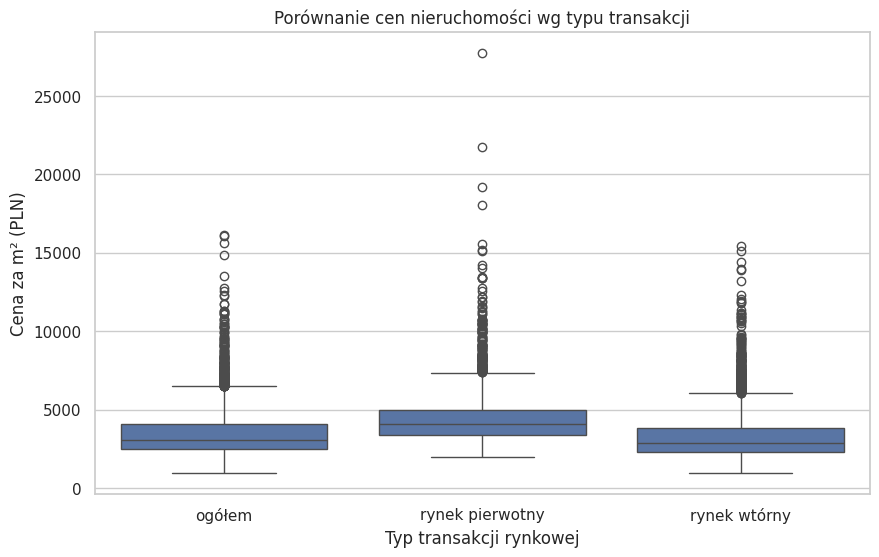

WNIOSKI: Wykres pudełkowy ujawnia liczne wartości odstające (outliery) powyżej górnego wąsa,
szczególnie na rynku wtórnym i ogółem. Sugeruje to obecność segmentu premium lub błędów,
co uzasadnia konieczność filtrowania danych do dalszych analiz statystycznych.
------------------------------------------------------------


,count,mean,std,min,25%,50%,75%,max
Transakcje rynkowe,,,,,,,,
ogółem,5400.0,3384.84,1279.03,957.0,2477.0,3054.0,4061.75,9026.0
rynek pierwotny,4029.0,4293.84,1213.25,2018.0,3417.0,4044.0,4939.00,9023.0
rynek wtórny,5407.0,3205.13,1255.74,957.0,2332.0,2849.0,3807.00,9021.0


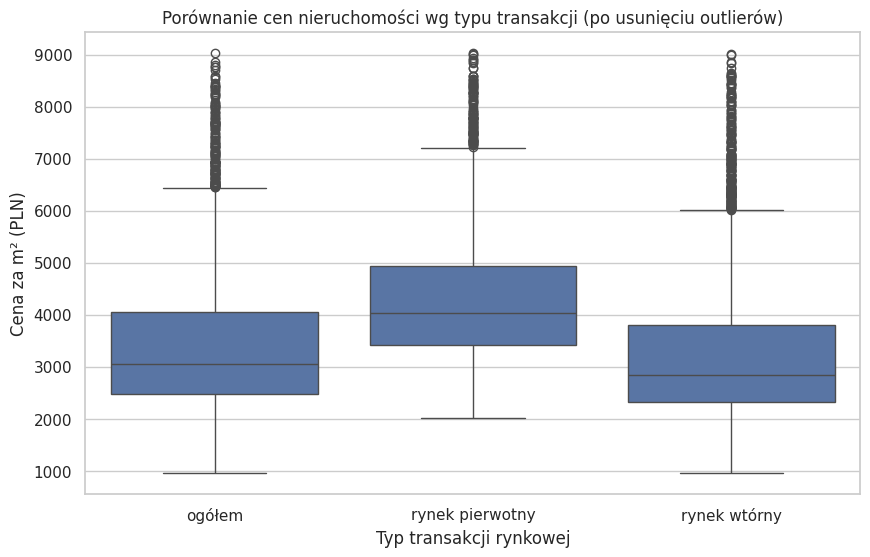

WNIOSKI: Po usunięciu outlierów widać, że rynek pierwotny posiada nie tylko wyższą medianę,
ale i większy rozstęp międzykwartylny (szersze pudełko) niż rynek wtórny.
Oznacza to większe zróżnicowanie cenowe ofert deweloperskich w porównaniu do mieszkań z drugiej ręki.


In [16]:
# 3. Statystyki opisowe i usuwanie outlierów
stats_desc = df_clean.groupby('Transakcje rynkowe')['cena_numeric'].describe().round(2)
display(stats_desc)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='Transakcje rynkowe', y='cena_numeric')
plt.title("Porównanie cen nieruchomości wg typu transakcji")
plt.xlabel("Typ transakcji rynkowej")
plt.ylabel("Cena za m² (PLN)")
plt.show()
print("WNIOSKI: Wykres pudełkowy ujawnia liczne wartości odstające (outliery) powyżej górnego wąsa,")
print("szczególnie na rynku wtórnym i ogółem. Sugeruje to obecność segmentu premium lub błędów,")
print("co uzasadnia konieczność filtrowania danych do dalszych analiz statystycznych.")

Q1 = df_clean['cena_numeric'].quantile(0.15)
Q3 = df_clean['cena_numeric'].quantile(0.85)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_outliers = df_clean[(df_clean['cena_numeric'] >= lower_bound) & (df_clean['cena_numeric'] <= upper_bound)].copy()

stats_desc = df_outliers.groupby('Transakcje rynkowe')['cena_numeric'].describe().round(2)
print("------------------------------------------------------------")
display(stats_desc)

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_outliers, x='Transakcje rynkowe', y='cena_numeric')
plt.title("Porównanie cen nieruchomości wg typu transakcji (po usunięciu outlierów)")
plt.xlabel("Typ transakcji rynkowej")
plt.ylabel("Cena za m² (PLN)")
plt.show()
print("WNIOSKI: Po usunięciu outlierów widać, że rynek pierwotny posiada nie tylko wyższą medianę,")
print("ale i większy rozstęp międzykwartylny (szersze pudełko) niż rynek wtórny.")
print("Oznacza to większe zróżnicowanie cenowe ofert deweloperskich w porównaniu do mieszkań z drugiej ręki.")

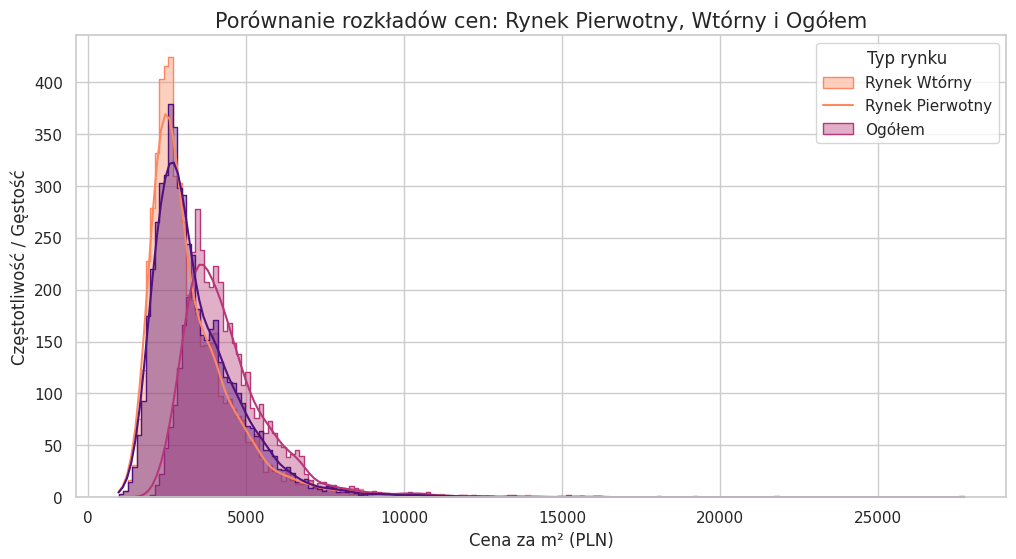

WNIOSKI: Rozkłady są wyraźnie asymetryczne prawostronnie (dodatnio skośne).
Krzywa KDE dla rynku pierwotnego jest przesunięta w prawo względem wtórnego, co potwierdza,
że nowe mieszkania stanowią droższy segment rynku o innej strukturze cenowej.
------------------------------------------------------------


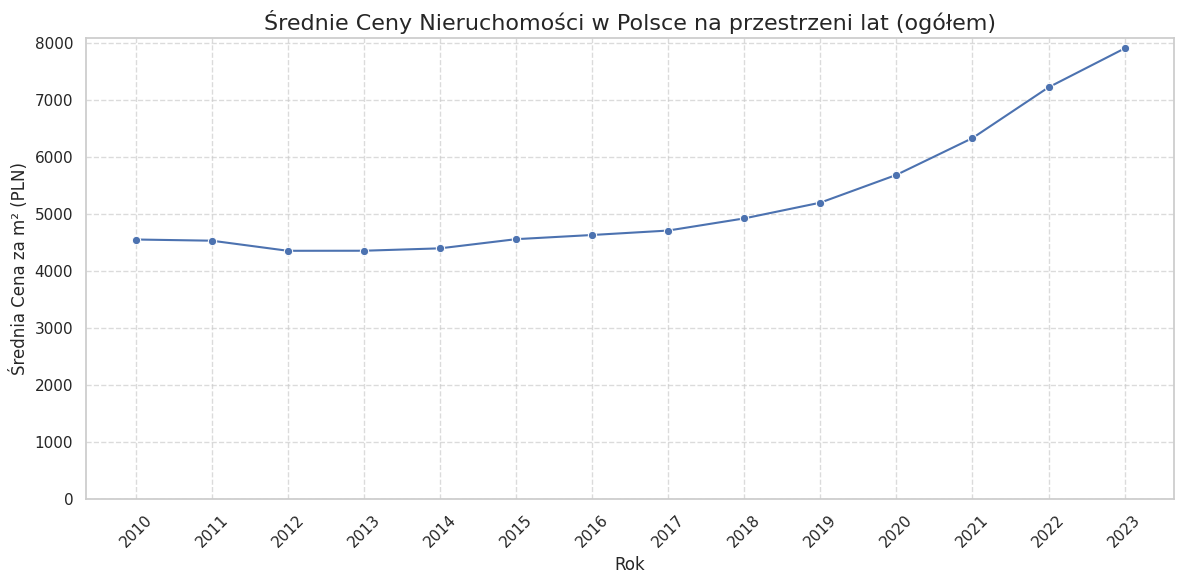

WNIOSKI: Trend liniowy pokazuje stabilny wzrost cen do około 2017 roku, po którym nastąpiło
wyraźne przyspieszenie dynamiki wzrostów. Świadczy to o gwałtownej aprecjacji wartości nieruchomości w ostatnich latach.
------------------------------------------------------------
------------------------------------------------------------


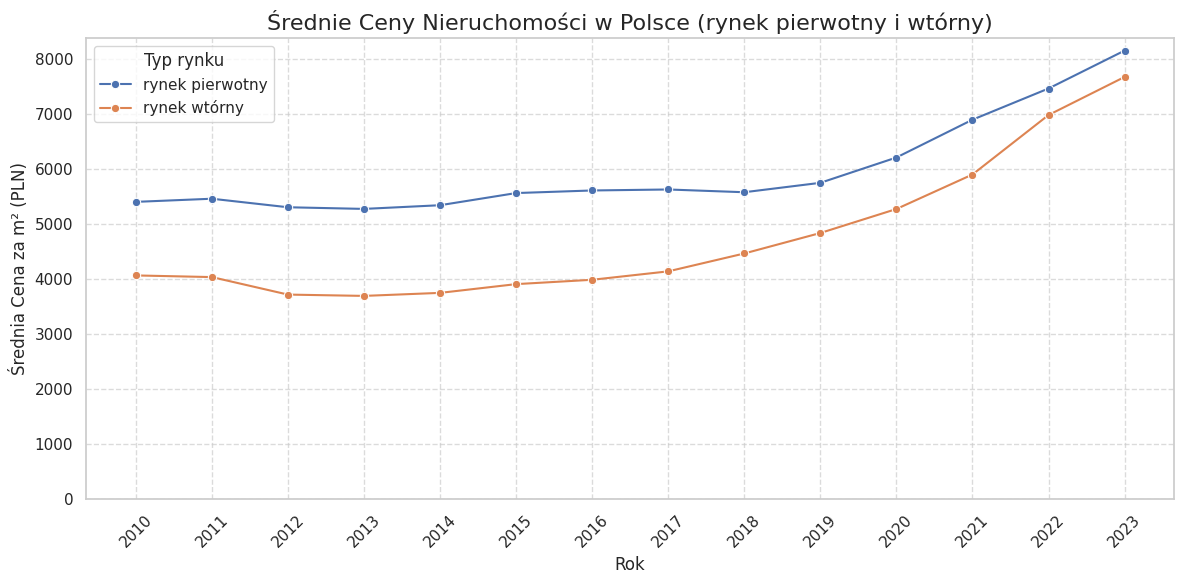

WNIOSKI: Rynek pierwotny konsekwentnie utrzymuje premię cenową nad wtórnym.
Obie serie czasowe są silnie skorelowane, co sugeruje, że czynniki makroekonomiczne
oddziałują na oba segmenty rynku w podobny sposób, zachowując stały dystans cenowy.


In [15]:
# 4. Wizualizacja rozkładu danych
sns.set_theme(style="whitegrid")
plt.figure(figsize=(12, 6))

plot_data = df_clean

sns.histplot(
    data=plot_data,
    x='cena_numeric',
    hue='Transakcje rynkowe',
    kde=True,
    element="step",
    palette='magma',
    alpha=0.4
)

plt.title('Porównanie rozkładów cen: Rynek Pierwotny, Wtórny i Ogółem', fontsize=15)
plt.xlabel('Cena za m² (PLN)', fontsize=12)
plt.ylabel('Częstotliwość / Gęstość', fontsize=12)
plt.legend(title='Typ rynku', labels=['Rynek Wtórny', 'Rynek Pierwotny', 'Ogółem'])
plt.show()
print("WNIOSKI: Rozkłady są wyraźnie asymetryczne prawostronnie (dodatnio skośne).")
print("Krzywa KDE dla rynku pierwotnego jest przesunięta w prawo względem wtórnego, co potwierdza,")
print("że nowe mieszkania stanowią droższy segment rynku o innej strukturze cenowej.")

print("------------------------------------------------------------")

df_polska = df_clean[
    (df_clean['Nazwa'] == 'POLSKA') &
    (df_clean['Transakcje rynkowe'] == 'ogółem')
].copy()

prices_polska_yearly = df_polska.groupby('Rok')['cena_numeric'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.lineplot(data=prices_polska_yearly, x='Rok', y='cena_numeric', marker='o')
plt.title('Średnie Ceny Nieruchomości w Polsce na przestrzeni lat (ogółem)', fontsize=16)
plt.xlabel('Rok', fontsize=12)
plt.ylabel('Średnia Cena za m² (PLN)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(prices_polska_yearly['Rok'].unique(), rotation=45)
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()
print("WNIOSKI: Trend liniowy pokazuje stabilny wzrost cen do około 2017 roku, po którym nastąpiło")
print("wyraźne przyspieszenie dynamiki wzrostów. Świadczy to o gwałtownej aprecjacji wartości nieruchomości w ostatnich latach.")

print("------------------------------------------------------------")

df_polska_markets = df_clean[
    (df_clean['Nazwa'] == 'POLSKA') &
    (df_clean['Transakcje rynkowe'].isin(['rynek pierwotny', 'rynek wtórny']))
].copy()

prices_polska_yearly_markets = df_polska_markets.groupby(['Rok', 'Transakcje rynkowe'])['cena_numeric'].mean().reset_index()
print("------------------------------------------------------------")
plt.figure(figsize=(12, 6))
sns.lineplot(data=prices_polska_yearly_markets, x='Rok', y='cena_numeric', hue='Transakcje rynkowe', marker='o')
plt.title('Średnie Ceny Nieruchomości w Polsce (rynek pierwotny i wtórny)', fontsize=16)
plt.xlabel('Rok', fontsize=12)
plt.ylabel('Średnia Cena za m² (PLN)', fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.xticks(prices_polska_yearly_markets['Rok'].unique(), rotation=45)
plt.legend(title='Typ rynku')
plt.ylim(bottom=0)
plt.tight_layout()
plt.show()
print("WNIOSKI: Rynek pierwotny konsekwentnie utrzymuje premię cenową nad wtórnym.")
print("Obie serie czasowe są silnie skorelowane, co sugeruje, że czynniki makroekonomiczne")
print("oddziałują na oba segmenty rynku w podobny sposób, zachowując stały dystans cenowy.")

In [ ]:
# Siatka wykresów
import math
import matplotlib.pyplot as plt

voiv = df.copy()
voiv["Rok"] = pd.to_numeric(voiv["Rok"], errors="coerce")
voiv["Wartosc"] = pd.to_numeric(voiv["Wartosc"], errors="coerce")
voiv = voiv.dropna(subset=["Rok", "Wartosc"])
voiv = voiv[voiv["Transakcje rynkowe"].str.contains("rynek pierwotny", case=False, na=False)]
voiv = voiv[~voiv["Nazwa"].str.contains("POLSKA|powiat|gmina", case=False, na=False)]

pct_rows = []
for name, wo in voiv.groupby("Nazwa"):
    wo = wo.sort_values("Rok")
    base = wo.iloc[0]["Wartosc"]
    if pd.isna(base) or base == 0:
        pct_rows.append(wo.assign(pct_vs_first=pd.NA))
    else:
        pct_rows.append(wo.assign(pct_vs_first=(wo["Wartosc"] / base - 1) * 100))

voiv_pct = pd.concat(pct_rows, ignore_index=True)
voiv_pct = voiv_pct.dropna(subset=["pct_vs_first"])

names = sorted(voiv_pct["Nazwa"].unique())
n = len(names)
cols = 4
rows = math.ceil(n / cols)
fig, axes = plt.subplots(rows, cols, figsize=(16, 3.2 * rows), sharex=True, sharey=True)
axes = axes.flatten()

for i, name in enumerate(names):
    ax = axes[i]
    wo = voiv_pct[voiv_pct["Nazwa"] == name]
    if wo.empty:
        ax.text(0.5, 0.5, "Brak danych", ha="center", va="center", transform=ax.transAxes)
    else:
        ax.plot(wo["Rok"], wo["pct_vs_first"], marker="o", linewidth=1.2, alpha=0.9)
    ax.set_title(name)
    ax.grid(True, linestyle=":", alpha=0.5)
    if i % cols == 0:
        ax.set_ylabel("Zmiana [%]")
    if i // cols == rows - 1:
        ax.set_xlabel("Rok")

for j in range(i + 1, len(axes)):
    axes[j].axis("off")

plt.tight_layout()
plt.show()
print("WNIOSKI: Wykresy zmian procentowych pokazują różną dynamikę lokalną.")
print("Podczas gdy niektóre województwa wykazują niemal liniowy wzrost, inne cechują się")
print("gwałtownymi skokami w ostatnich latach, co wskazuje na lokalne bańki lub gwałtowny wzrost popytu.")

Średnie ceny nieruchomości dla województw


,Nazwa,cena_numeric
0,DOLNOŚLĄSKIE,5004.785714
1,KUJAWSKO-POMORSKIE,4130.357143
2,LUBELSKIE,4766.428571
3,LUBUSKIE,3400.809524
4,MAZOWIECKIE,7395.571429
5,MAŁOPOLSKIE,6670.428571
6,OPOLSKIE,3641.047619
7,PODKARPACKIE,4146.452381
8,PODLASKIE,4582.452381
9,POMORSKIE,5909.500000


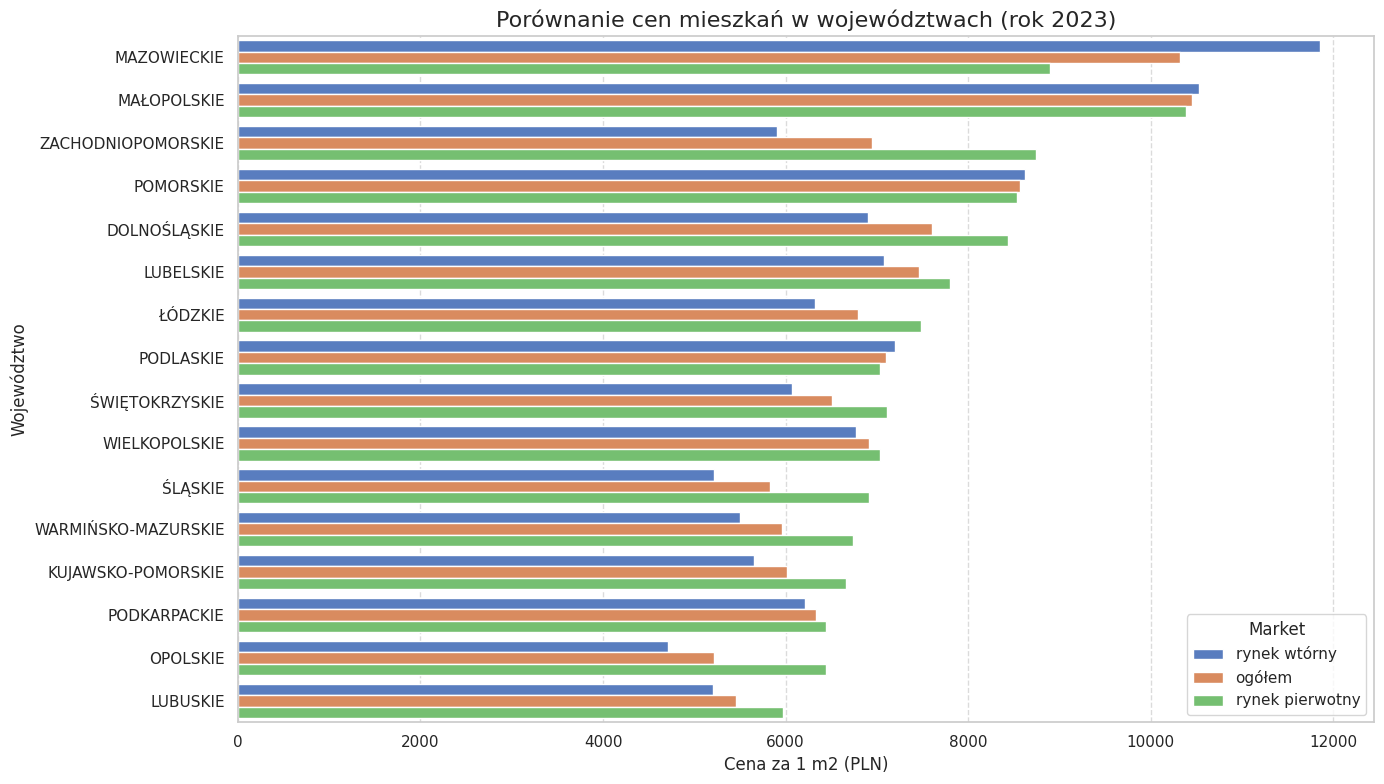

WNIOSKI: W 2023 roku różnice regionalne są drastyczne – Mazowieckie dominuje nad resztą stawki.
Wysoka cena na rynku pierwotnym w topowych województwach sugeruje silną koncentrację
inwestycji deweloperskich w najbogatszych regionach kraju.


In [17]:
voivodeships = [
    'DOLNOŚLĄSKIE', 'KUJAWSKO-POMORSKIE', 'LUBELSKIE', 'LUBUSKIE',
    'ŁÓDZKIE', 'MAŁOPOLSKIE', 'MAZOWIECKIE', 'OPOLSKIE', 'PODKARPACKIE',
    'PODLASKIE', 'POMORSKIE', 'ŚLĄSKIE', 'ŚWIĘTOKRZYSKIE',
    'WARMIŃSKO-MAZURSKIE', 'WIELKOPOLSKIE', 'ZACHODNIOPOMORSKIE'
]

df_voivodeships = df_clean[df_clean['Nazwa'].isin(voivodeships)]
average_prices_by_voivodeship = df_voivodeships.groupby('Nazwa')['cena_numeric'].mean().reset_index()

styled_table = average_prices_by_voivodeship.style\
    .background_gradient(cmap='Greens', subset=['cena_numeric']) \
    .set_properties(**{'border-color': '#0a0a0a', 'border-style': 'solid', 'border-width': '1px'}) \
    .set_table_styles([{'selector': 'td, th', 'props': [('border', '1px solid #0a0a0a')]}])

print("Średnie ceny nieruchomości dla województw")
display(styled_table)

df_processed = df.copy()
df_processed.rename(columns={'Nazwa': 'Region', 'Transakcje rynkowe': 'Market', 'Rok': 'Year', 'Wartosc': 'Price'}, inplace=True)
df_processed['Price'] = pd.to_numeric(df_processed['Price'], errors='coerce')
df_processed = df_processed[df_processed['Price'] > 0]

latest_year = 2023
df_2023 = df_processed[(df_processed['Region'].isin(voivodeships)) & (df_processed['Year'] == latest_year)].copy()

summary_pivot = df_2023.pivot(index='Region', columns='Market', values='Price')
summary_pivot['Różnica (P-W)'] = summary_pivot['rynek pierwotny'] - summary_pivot['rynek wtórny']
summary_pivot = summary_pivot.sort_values(by='rynek pierwotny', ascending=False)

plt.figure(figsize=(14, 8))
df_plot = df_2023.sort_values(by='Price', ascending=False)
sns.barplot(data=df_plot, y='Region', x='Price', hue='Market', palette='muted')
plt.title(f'Porównanie cen mieszkań w województwach (rok {latest_year})', fontsize=16)
plt.xlabel('Cena za 1 m2 (PLN)', fontsize=12)
plt.ylabel('Województwo', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
print(f"WNIOSKI: W 2023 roku różnice regionalne są drastyczne – Mazowieckie dominuje nad resztą stawki.")
print("Wysoka cena na rynku pierwotnym w topowych województwach sugeruje silną koncentrację")
print("inwestycji deweloperskich w najbogatszych regionach kraju.")

------------------------------------------------------------


,Województwo,Najdroższy Powiat,Cena Max [zł/m2],Najtańszy Powiat,Cena Min [zł/m2]
0,DOLNOŚLĄSKIE,Powiat m. Wrocław,10151,Powiat górowski,2591
1,KUJAWSKO-POMORSKIE,Powiat m. Toruń,7545,Powiat grudziądzki,3031
2,LUBELSKIE,Powiat m. Lublin,8593,Powiat zamojski,2892
3,LUBUSKIE,Powiat m. Zielona Góra,6708,Powiat żagański,3440
4,ŁÓDZKIE,Powiat m. Łódź,7365,Powiat skierniewicki,2927
5,MAŁOPOLSKIE,Powiat tatrzański,16104,Powiat suski,4466
6,MAZOWIECKIE,Powiat m. st. Warszawa,13498,Powiat przysuski,3800
7,OPOLSKIE,Powiat m. Opole,7140,Powiat głubczycki,2919
8,PODKARPACKIE,Powiat m. Rzeszów,7612,Powiat lubaczowski,2874
9,PODLASKIE,Powiat m. Białystok,7899,Powiat suwalski,3110


------------------------------------------------------------


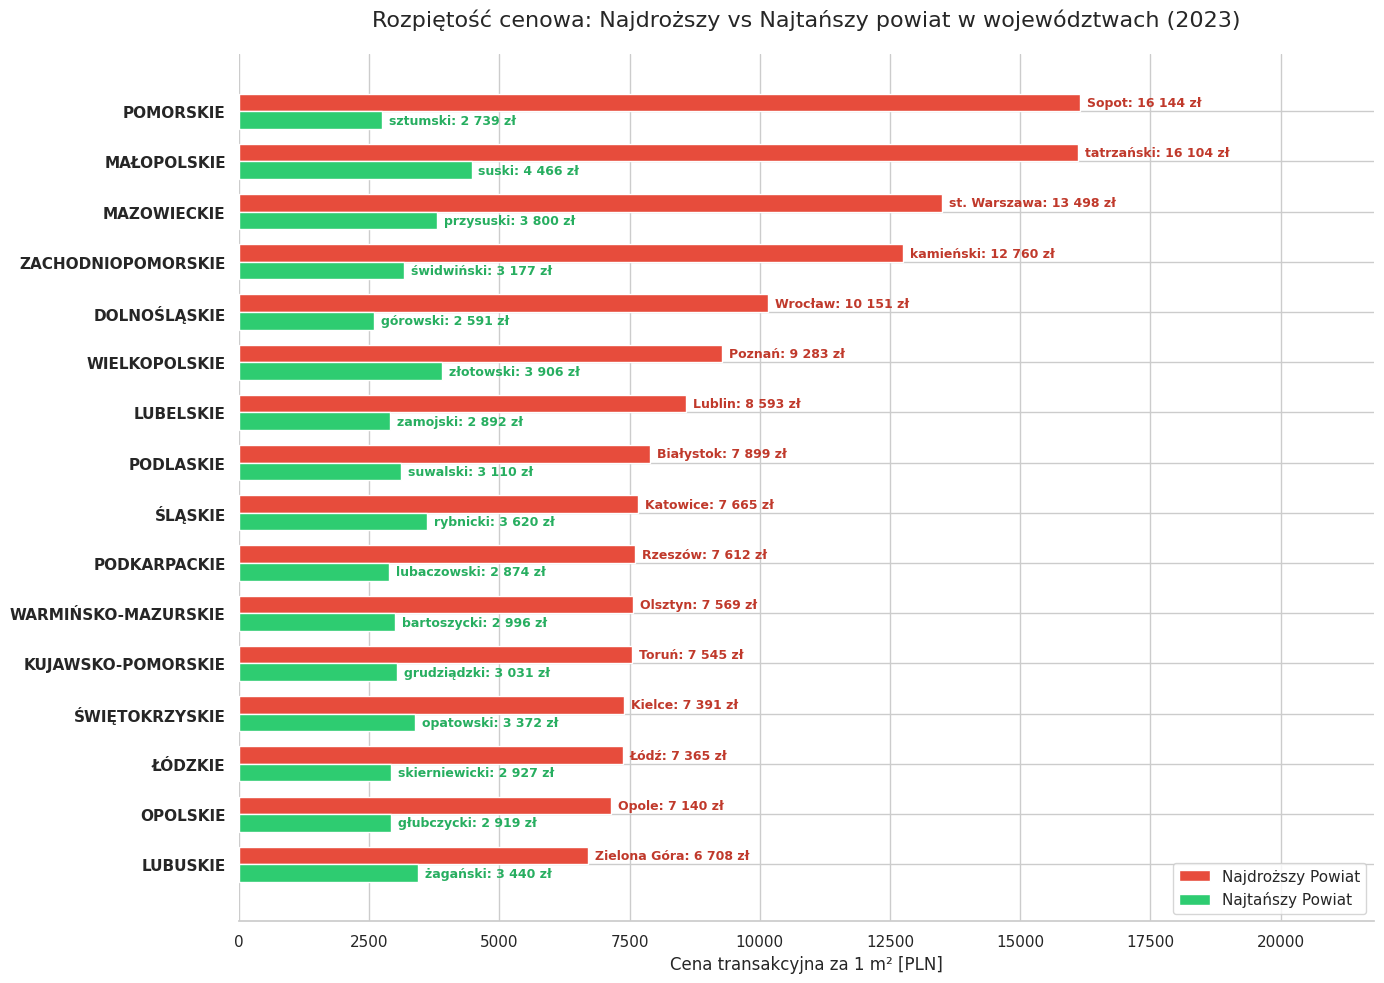

WNIOSKI: Wykres uwidacznia ogromną polaryzację wewnątrzwojewódzką.
Średnia cena wojewódzka jest silnie zawyżana przez stolice regionów, podczas gdy
powiaty peryferyjne oferują nieruchomości nawet o połowę tańsze w tym samym województwie.


In [18]:
# Analiza najdroższych i najtańszych powiatów
df['Wartosc'] = df['Wartosc'].astype(str).str.replace(' ', '')
df['Wartosc'] = pd.to_numeric(df['Wartosc'].replace('-', np.nan), errors='coerce')

print("------------------------------------------------------------")
df['Wojewodztwo'] = df['Nazwa'].apply(lambda x: x if x in voivodeships else np.nan).ffill()
mask = (
    (df['Rok'] == 2023) &
    (df['Transakcje rynkowe'] == 'ogółem') &
    (~df['Nazwa'].isin(voivodeships)) &
    (df['Nazwa'] != 'POLSKA') &
    (df['Nazwa'].str.contains('Powiat', na=False))
)
df_2023_pow = df[mask].copy()

wyniki = []
for woj in df_2023_pow['Wojewodztwo'].unique():
    grupa = df_2023_pow[df_2023_pow['Wojewodztwo'] == woj]
    if grupa.empty: continue
    najdrozszy = grupa.loc[grupa['Wartosc'].idxmax()]
    najtanszy = grupa.loc[grupa['Wartosc'].idxmin()]
    wyniki.append({
        'Województwo': woj,
        'Najdroższy Powiat': najdrozszy['Nazwa'],
        'Cena Max [zł/m2]': najdrozszy['Wartosc'],
        'Najtańszy Powiat': najtanszy['Nazwa'],
        'Cena Min [zł/m2]': najtanszy['Wartosc']
    })

df_wynik = pd.DataFrame(wyniki)
display(df_wynik)

print("------------------------------------------------------------")
df_wynik['Cena Max [zł/m2]'] = pd.to_numeric(df_wynik['Cena Max [zł/m2]'])
df_wynik['Cena Min [zł/m2]'] = pd.to_numeric(df_wynik['Cena Min [zł/m2]'])
df_plot_pow = df_wynik.sort_values('Cena Max [zł/m2]', ascending=True)

sns.set_style("whitegrid")
fig, ax = plt.subplots(figsize=(14, 10))
y = np.arange(len(df_plot_pow))
height = 0.35

rects_max = ax.barh(y + height/2, df_plot_pow['Cena Max [zł/m2]'], height, label='Najdroższy Powiat', color='#e74c3c', edgecolor='white')
rects_min = ax.barh(y - height/2, df_plot_pow['Cena Min [zł/m2]'], height, label='Najtańszy Powiat', color='#2ecc71', edgecolor='white')

def dodaj_etykiety(rects, nazwy_powiatow, kolor):
    for rect, nazwa in zip(rects, nazwy_powiatow):
        width = rect.get_width()
        nazwa_krotka = nazwa.replace('Powiat ', '').replace('m. ', '')
        label_text = f'{nazwa_krotka}: {int(width):,} zł'.replace(',', ' ')
        ax.annotate(label_text, xy=(width, rect.get_y() + rect.get_height() / 2), xytext=(5, 0), textcoords="offset points", ha='left', va='center', fontsize=9, fontweight='bold', color=kolor)

dodaj_etykiety(rects_max, df_plot_pow['Najdroższy Powiat'], '#c0392b')
dodaj_etykiety(rects_min, df_plot_pow['Najtańszy Powiat'], '#27ae60')

ax.set_yticks(y)
ax.set_yticklabels(df_plot_pow['Województwo'], fontsize=11, fontweight='bold')
ax.set_xlabel('Cena transakcyjna za 1 m² [PLN]', fontsize=12)
ax.set_title('Rozpiętość cenowa: Najdroższy vs Najtańszy powiat w województwach (2023)', fontsize=16, pad=20)
ax.legend(loc='lower right', frameon=True)
sns.despine(left=True, bottom=False)
ax.set_xlim(0, df_plot_pow['Cena Max [zł/m2]'].max() * 1.35)
plt.tight_layout()
plt.show()
print("WNIOSKI: Wykres uwidacznia ogromną polaryzację wewnątrzwojewódzką.")
print("Średnia cena wojewódzka jest silnie zawyżana przez stolice regionów, podczas gdy")
print("powiaty peryferyjne oferują nieruchomości nawet o połowę tańsze w tym samym województwie.")

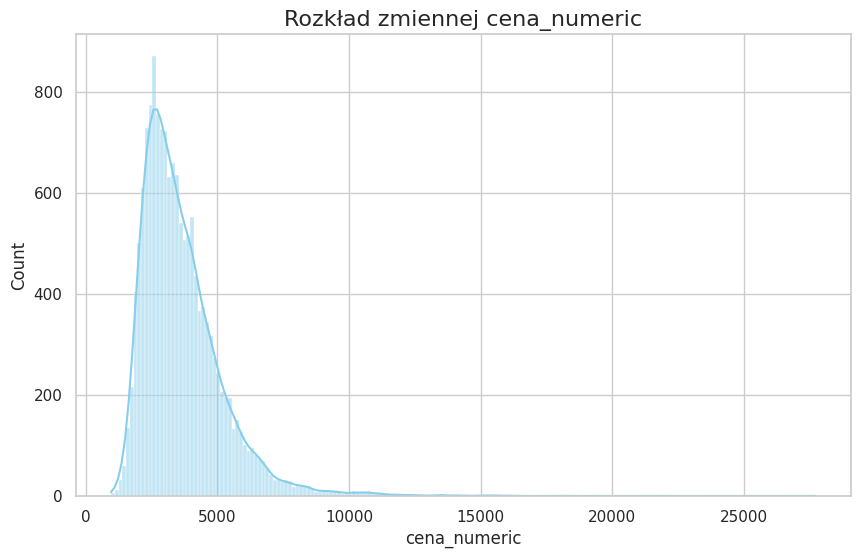

WNIOSKI: Rozkład zmiennej cena_numeric wykazuje asymetrię prawostronną.
Długi 'ogon' po prawej stronie wskazuje na to, że testy oparte na średniej mogą być
obciążone przez segmenty luksusowe, co sugeruje użycie statystyk odpornych.


In [27]:
# 8. Sprawdzenie założeń
plt.figure(figsize=(10, 6))
sns.histplot(df_clean['cena_numeric'], kde=True, color='skyblue')
plt.title('Rozkład zmiennej cena_numeric', fontsize=16)
plt.show()
print("WNIOSKI: Rozkład zmiennej cena_numeric wykazuje asymetrię prawostronną.")
print("Długi 'ogon' po prawej stronie wskazuje na to, że testy oparte na średniej mogą być")
print("obciążone przez segmenty luksusowe, co sugeruje użycie statystyk odpornych.")

<Figure size 800x600 with 0 Axes>

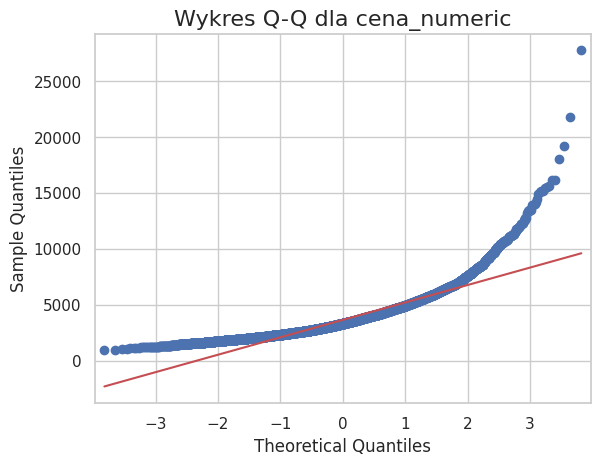

WNIOSKI: Odchylenia punktów od linii prostej na wykresie Q-Q potwierdzają brak normalności.
Szczególnie 'ciężkie ogony' rozkładu dowodzą, że założenia klasycznej ANOVA nie są tutaj spełnione.


In [28]:
#Wykres Q-Q dla cena_numeric
plt.figure(figsize=(8, 6))
sm.qqplot(df_clean['cena_numeric'], line='s')
plt.title('Wykres Q-Q dla cena_numeric', fontsize=16)
plt.show()
print("WNIOSKI: Odchylenia punktów od linii prostej na wykresie Q-Q potwierdzają brak normalności.")
print("Szczególnie 'ciężkie ogony' rozkładu dowodzą, że założenia klasycznej ANOVA nie są tutaj spełnione.")


Test Shapiro-Wilka dla 'cena_numeric':
Statystyka testowa = 0.8537, p-wartość = 0.0000


/usr/local/lib/python3.12/dist-packages/scipy/stats/_axis_nan_policy.py:579: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 14996.
  res = hypotest_fun_out(*samples, **kwds)


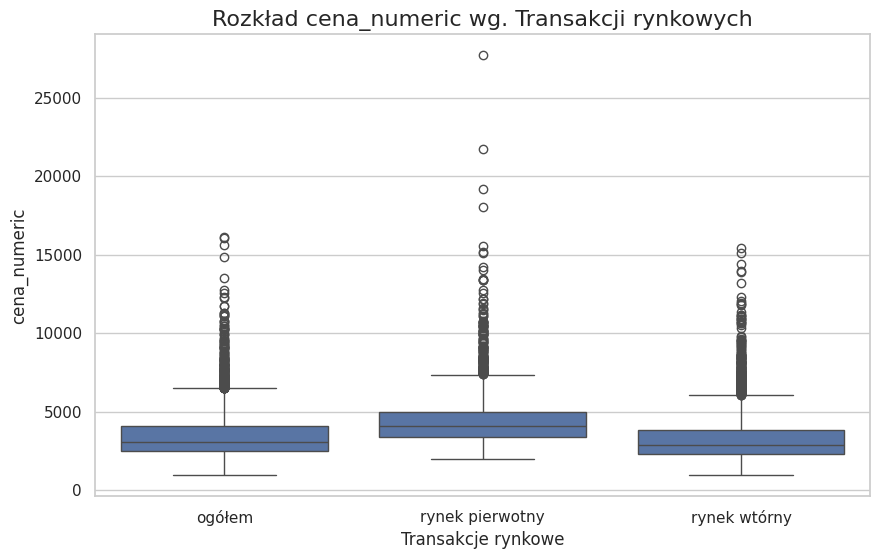

WNIOSKI: Różnice w rozmiarach pudełek sugerują heteroskedastyczność (brak jednorodności wariancji).
Wariancja cen na rynku pierwotnym jest wyższa, co wynika z różnorodnego standardu deweloperskiego.


In [29]:
#Test Shapiro-Wilka
shapiro_test = stats.shapiro(df_clean['cena_numeric'])
print(f"\nTest Shapiro-Wilka dla 'cena_numeric':\nStatystyka testowa = {shapiro_test.statistic:.4f}, p-wartość = {shapiro_test.pvalue:.4f}")

plt.figure(figsize=(10, 6))
sns.boxplot(data=df_clean, x='Transakcje rynkowe', y='cena_numeric')
plt.title('Rozkład cena_numeric wg. Transakcji rynkowych', fontsize=16)
plt.show()
print("WNIOSKI: Różnice w rozmiarach pudełek sugerują heteroskedastyczność (brak jednorodności wariancji).")
print("Wariancja cen na rynku pierwotnym jest wyższa, co wynika z różnorodnego standardu deweloperskiego.")

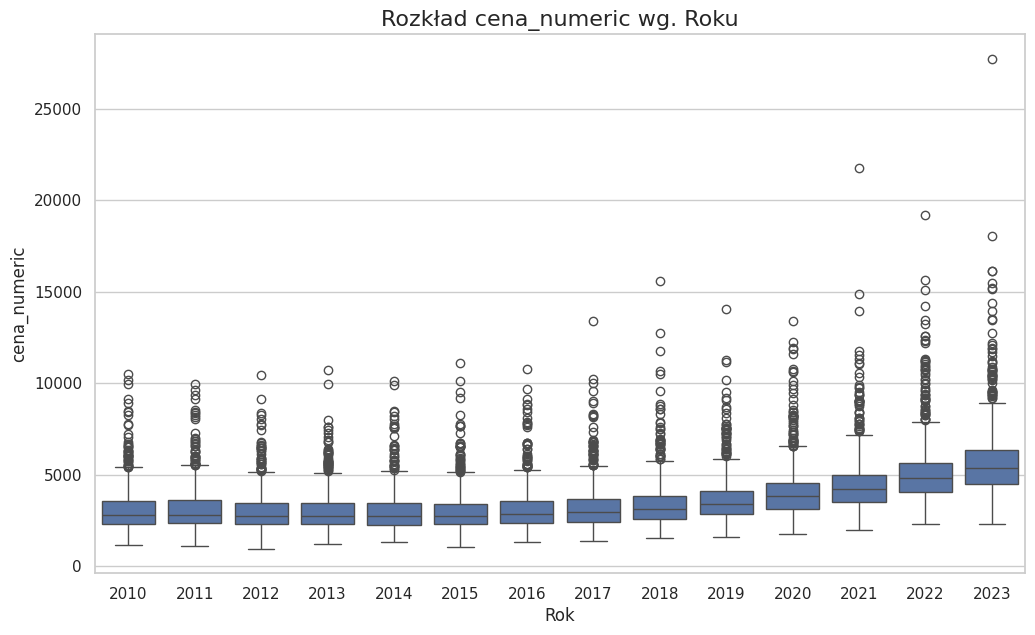

WNIOSKI: Wraz z upływem lat rośnie nie tylko średnia cena, ale i jej zmienność (wariancja).
Wizualnie potwierdza to naruszenie założenia o jednorodności wariancji w czasie.


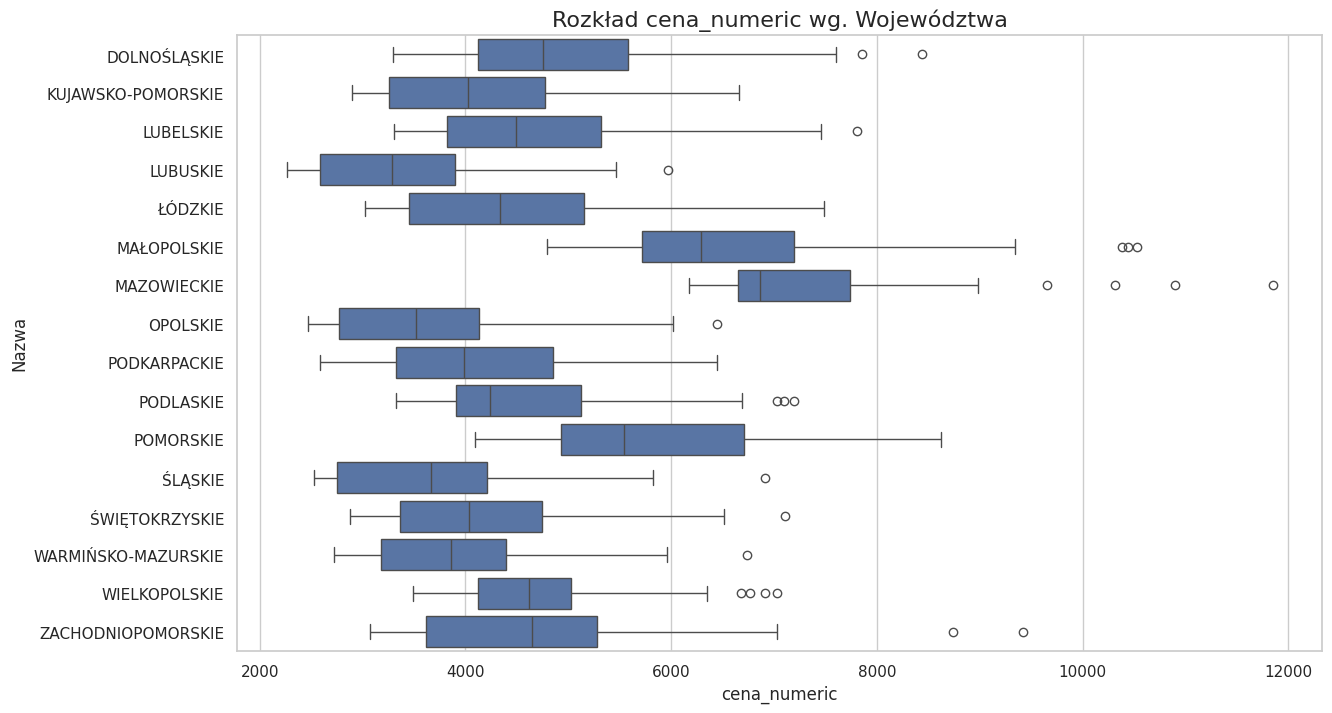

WNIOSKI: Rozkłady wewnątrzwojewódzkie różnią się istotnie pod względem szerokości.
Potwierdza to konieczność stosowania testu Welch's ANOVA, który jest odporny na brak równości wariancji.

Test Levene'a dla 'Transakcje rynkowe':
Statystyka testowa = 6.5595, p-wartość = 0.0014

Test Levene'a dla 'Rok':
Statystyka testowa = 24.7711, p-wartość = 0.0000


In [25]:
#Rozkład cena_numeric wg. Roku
plt.figure(figsize=(12, 7))
sns.boxplot(data=df_clean, x='Rok', y='cena_numeric')
plt.title('Rozkład cena_numeric wg. Roku', fontsize=16)
plt.show()
print("WNIOSKI: Wraz z upływem lat rośnie nie tylko średnia cena, ale i jej zmienność (wariancja).")
print("Wizualnie potwierdza to naruszenie założenia o jednorodności wariancji w czasie.")

df_voivodeships_outliers = df_clean[df_clean['Nazwa'].isin(voivodeships)].copy()
if not df_voivodeships_outliers.empty:
    plt.figure(figsize=(14, 8))
    sns.boxplot(data=df_voivodeships_outliers, x='cena_numeric', y='Nazwa')
    plt.title('Rozkład cena_numeric wg. Województwa', fontsize=16)
    plt.show()
    print("WNIOSKI: Rozkłady wewnątrzwojewódzkie różnią się istotnie pod względem szerokości.")
    print("Potwierdza to konieczność stosowania testu Welch's ANOVA, który jest odporny na brak równości wariancji.")

groups_market = [df_clean['cena_numeric'][df_clean['Transakcje rynkowe'] == cat] for cat in df_clean['Transakcje rynkowe'].unique()]
levene_market = stats.levene(*groups_market)
print(f"\nTest Levene'a dla 'Transakcje rynkowe':\nStatystyka testowa = {levene_market.statistic:.4f}, p-wartość = {levene_market.pvalue:.4f}")

groups_rok = [df_clean['cena_numeric'][df_clean['Rok'] == r] for r in df_clean['Rok'].unique()]
levene_rok = stats.levene(*groups_rok)
print(f"\nTest Levene'a dla 'Rok':\nStatystyka testowa = {levene_rok.statistic:.4f}, p-wartość = {levene_rok.pvalue:.4f}")


--- Welch's ANOVA dla 'Transakcje rynkowe' ---
statistic = 734.1931526867207
pvalue = 4.1509726435591815e-297
df = (2.0, np.float64(9449.277878609888))
df_num = 2.0
df_denom = 9449.277878609888
nobs_t = 14996.0
n_groups = 3
means = [3451.76784731 4419.50987564 3261.26900477]
nobs = [5449. 4101. 5446.]
vars_ = [2144242.32733606 2494153.47045123 2022961.72064426]
use_var = unequal
welch_correction = True
tuple = (np.float64(734.1931526867207), np.float64(4.1509726435591815e-297))

--- Welch's ANOVA dla 'Rok' ---
statistic = 338.3198353703691
pvalue = 0.0
df = (13.0, np.float64(5753.512224748787))
df_num = 13.0
df_denom = 5753.512224748787
nobs_t = 14996.0
n_groups = 14
means = [3078.05170631 3114.72306143 3009.35443038 2978.60153257 2982.49000951
     2996.62488129 3091.66510758 3186.41866913 3379.23566879 3631.02350814
     4016.49863512 4446.63384064 5073.60544815 5644.73153779]
nobs = [ 967.  993. 1027. 1044. 1051. 1053. 1069. 1082. 1099. 1106. 1099. 1117.
     1138. 1151.]
vars_ = [

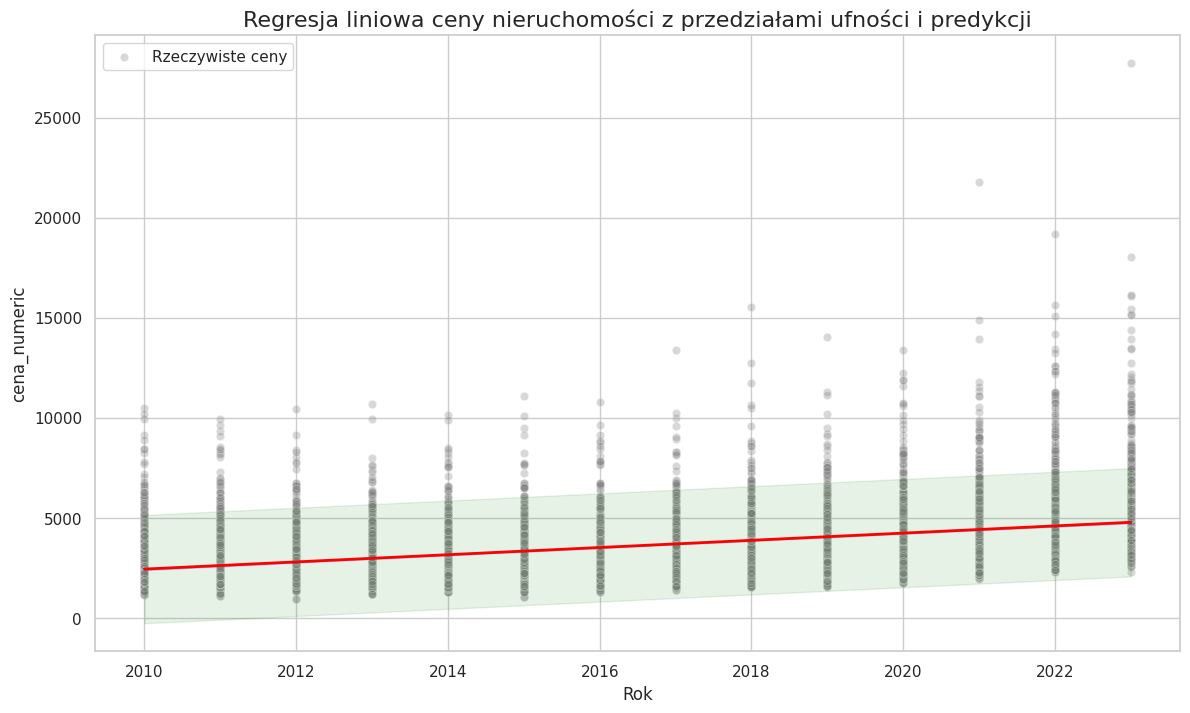

WNIOSKI: Model regresji wykazuje silną korelację dodatnią czasu z ceną.
Szeroki zielony obszar (przedział predykcji) dowodzi jednak, że zmienna czasowa wyjaśnia
jedynie trend ogólny, a nie cenę konkretnej nieruchomości, która zależy od wielu innych czynników.


In [20]:
# 9. Robust ANOVA
print("\n--- Welch's ANOVA dla 'Transakcje rynkowe' ---")
groups_market_welch = [df_clean['cena_numeric'][df_clean['Transakcje rynkowe'] == cat] for cat in df_clean['Transakcje rynkowe'].unique()]
anova_market = anova_oneway(groups_market_welch, use_var='unequal')
print(anova_market)

print("\n--- Welch's ANOVA dla 'Rok' ---")
groups_rok_welch = [df_clean['cena_numeric'][df_clean['Rok'] == r] for r in df_clean['Rok'].unique()]
anova_rok = anova_oneway(groups_rok_welch, use_var='unequal')
print(anova_rok)

print("\n--- Welch's ANOVA dla 'Nazwa' (województwa) ---")
if not df_voivodeships_outliers.empty:
    groups_nazwa_welch = [df_voivodeships_outliers['cena_numeric'][df_voivodeships_outliers['Nazwa'] == n] for n in df_voivodeships_outliers['Nazwa'].unique()]
    anova_nazwa = anova_oneway(groups_nazwa_welch, use_var='unequal')
    print(anova_nazwa)

# Regresja
model = smf.ols('cena_numeric ~ Rok', data=df_clean)
results = model.fit()
print(results.summary())

min_rok = df_clean['Rok'].min()
max_rok = df_clean['Rok'].max()
pred_years = pd.DataFrame({'Rok': np.arange(min_rok, max_rok + 1)})
predictions = results.get_prediction(pred_years)
pred_summary = predictions.summary_frame(alpha=0.05)

plt.figure(figsize=(14, 8))
sns.scatterplot(data=df_clean, x='Rok', y='cena_numeric', alpha=0.3, label='Rzeczywiste ceny', color='gray')
plt.plot(pred_years['Rok'], pred_summary['mean'], color='red', linewidth=2, label='Linia regresji (predykcja)')
plt.fill_between(pred_years['Rok'], pred_summary['mean_ci_lower'], pred_summary['mean_ci_upper'], color='blue', alpha=0.2, label='95% Przedział ufności dla średniej')
plt.fill_between(pred_years['Rok'], pred_summary['obs_ci_lower'], pred_summary['obs_ci_upper'], color='green', alpha=0.1, label='95% Przedział predykcji dla obserwacji')
plt.title('Regresja liniowa ceny nieruchomości z przedziałami ufności i predykcji', fontsize=16)
plt.show()
print("WNIOSKI: Model regresji wykazuje silną korelację dodatnią czasu z ceną.")
print("Szeroki zielony obszar (przedział predykcji) dowodzi jednak, że zmienna czasowa wyjaśnia")
print("jedynie trend ogólny, a nie cenę konkretnej nieruchomości, która zależy od wielu innych czynników.")

In [24]:
# Raport końcowy
raport_tekst = """
# Raport końcowy: Analiza rynku nieruchomości w Polsce

## 1. Wstęp i przygotowanie danych
Celem analizy było zbadanie struktury cenowej mieszkań. Kluczowym etapem było usunięcie błędnych wartości zerowych oraz zastosowanie metody IQR. Dzięki temu wyeliminowano skrajne odchylenia (outliery), co pozwoliło na rzetelną ocenę typowych transakcji rynkowych bez wpływu ekstremalnie drogich apartamentów.

## 2. Analiza eksploracyjna (EDA) i trendy
* **Segmentacja i zmienność:** Rynek pierwotny jest nie tylko droższy, ale wykazuje znacznie większą wariancję (szersze pudełka na wykresie boxplot). Oznacza to, że oferta deweloperska jest bardziej zróżnicowana cenowo niż rynek wtórny.
* **Dynamika trendu:** Wykresy liniowe wskazują na punkt przegięcia w okolicach 2017 roku, po którym nastąpił gwałtowny wzrost cen. Rynek pierwotny i wtórny rosną niemal równolegle, zachowując stałą lukę cenową.
* **Analiza regionalna:** Województwa mazowieckie i małopolskie liderują pod względem cen, jednak wykresy powiatowe ujawniają drastyczne dysproporcje – wewnątrz jednego regionu różnica między najdroższym a najtańszym powiatem jest często dwukrotna.

## 3. Wnioskowanie statystyczne
* **Weryfikacja założeń:** Testy Shapiro-Wilka (normalność) oraz Levene'a (wariancja) dały wyniki istotne statystycznie ($p < 0.05$), co oznacza naruszenie klasycznych założeń. Rozkład cen jest prawostronnie asymetryczny, a zmienność cen rośnie wraz z upływem lat (heteroskedastyczność).
* **Testy odporne:** Wykorzystanie Welch's ANOVA potwierdziło, że typ rynku, rok oraz lokalizacja są niezależnymi, silnymi determinantami cen, a zaobserwowane różnice między nimi nie są dziełem przypadku.

## 4. Modelowanie (Regresja liniowa)
Model OLS matematycznie potwierdza trend wzrostowy. Wizualizacja przedziałów pokazuje wąski margines błędu dla średniej ceny, ale bardzo szeroki przedział predykcji dla pojedynczych obserwacji. Oznacza to, że model świetnie przewiduje kierunek rynku, ale sam rok to za mało, by precyzyjnie wycenić konkretne mieszkanie.

## 5. Podsumowanie
Rynek nieruchomości staje się coraz bardziej złożony i zmienny. Wysoka wariancja w ostatnich latach sugeruje większe ryzyko inwestycyjne. Kluczowym wnioskiem jest konieczność analizy lokalnej – średnie wojewódzkie są mocno zawyżane przez stolice regionów, co maskuje znacznie niższe ceny w powiatach ościennych.
"""
display(Markdown(raport_tekst))


# Raport końcowy: Analiza rynku nieruchomości w Polsce

## 1. Wstęp i przygotowanie danych
Celem analizy było zbadanie struktury cenowej mieszkań. Kluczowym etapem było usunięcie błędnych wartości zerowych oraz zastosowanie metody IQR. Dzięki temu wyeliminowano skrajne odchylenia (outliery), co pozwoliło na rzetelną ocenę typowych transakcji rynkowych bez wpływu ekstremalnie drogich apartamentów.

## 2. Analiza eksploracyjna (EDA) i trendy
* **Segmentacja i zmienność:** Rynek pierwotny jest nie tylko droższy, ale wykazuje znacznie większą wariancję (szersze pudełka na wykresie boxplot). Oznacza to, że oferta deweloperska jest bardziej zróżnicowana cenowo niż rynek wtórny.
* **Dynamika trendu:** Wykresy liniowe wskazują na punkt przegięcia w okolicach 2017 roku, po którym nastąpił gwałtowny wzrost cen. Rynek pierwotny i wtórny rosną niemal równolegle, zachowując stałą lukę cenową.
* **Analiza regionalna:** Województwa mazowieckie i małopolskie liderują pod względem cen, jednak wykresy powiatowe ujawniają drastyczne dysproporcje – wewnątrz jednego regionu różnica między najdroższym a najtańszym powiatem jest często dwukrotna.

## 3. Wnioskowanie statystyczne
* **Weryfikacja założeń:** Testy Shapiro-Wilka (normalność) oraz Levene'a (wariancja) dały wyniki istotne statystycznie ($p < 0.05$), co oznacza naruszenie klasycznych założeń. Rozkład cen jest prawostronnie asymetryczny, a zmienność cen rośnie wraz z upływem lat (heteroskedastyczność).
* **Testy odporne:** Wykorzystanie Welch's ANOVA potwierdziło, że typ rynku, rok oraz lokalizacja są niezależnymi, silnymi determinantami cen, a zaobserwowane różnice między nimi nie są dziełem przypadku.

## 4. Modelowanie (Regresja liniowa)
Model OLS matematycznie potwierdza trend wzrostowy. Wizualizacja przedziałów pokazuje wąski margines błędu dla średniej ceny, ale bardzo szeroki przedział predykcji dla pojedynczych obserwacji. Oznacza to, że model świetnie przewiduje kierunek rynku, ale sam rok to za mało, by precyzyjnie wycenić konkretne mieszkanie.

## 5. Podsumowanie 
Rynek nieruchomości staje się coraz bardziej złożony i zmienny. Wysoka wariancja w ostatnich latach sugeruje większe ryzyko inwestycyjne. Kluczowym wnioskiem jest konieczność analizy lokalnej – średnie wojewódzkie są mocno zawyżane przez stolice regionów, co maskuje znacznie niższe ceny w powiatach ościennych.
